The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- primary color id
- secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.



In [1]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

In [2]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive/etsy_train_test"
!ls "$path"


test  train


In [ ]:
parquet_filenames_train = !ls '/content/drive/My Drive/etsy_train_test/train'

In [ ]:
parquet_filenames_train = [filename for line in parquet_filenames_train for filename in line.split()]

In [ ]:
parquet_filenames_train[:3]

['part-00206-of-00362.parquet',
 'part-00258-of-00362.parquet',
 'part-00310-of-00362.parquet']

In [ ]:
#def read_all_parquet_files(folder_path):
    dataframes = []
    filenames = os.listdir(folder_path)

    for filename in filenames:
        if filename.endswith('.parquet'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_parquet(file_path)
            dataframes.append(df)

    return pd.concat(dataframes)

folder_path = "/content/drive/My Drive/data_etsy_train/"
df_train = read_all_parquet_files(folder_path)

In [6]:
def read_all_parquet_files(folder_path, limit=100):
    dataframes = []
    filenames = os.listdir(folder_path)
    files_read = 0

    for filename in filenames:
        if filename.endswith('.parquet'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_parquet(file_path)
            dataframes.append(df)
            files_read += 1
            if files_read >= limit:
                break

    return pd.concat(dataframes)

folder_path = "/content/drive/My Drive/etsy_train_test/train"
df_train = read_all_parquet_files(folder_path, limit=100)

In [ ]:
def read_all_parquet_files(folder_path, limit=100):
    dataframes = []
    filenames = os.listdir(folder_path)
    files_read = 0

    for filename in filenames:
        if filename.endswith('.parquet'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_parquet(file_path)
            dataframes.append(df)
            files_read += 1
            if files_read >= limit:
                break

    return pd.concat(dataframes)

folder_path = "/content/drive/My Drive/etsy_train_test/test"
df_test = read_all_parquet_files(folder_path)

In [ ]:
df_train.shape

(65298, 26)

In [ ]:
df_test.shape

(7631, 18)

In [ ]:
df_test.head(5)

product_id                                              title  \
0   544963910    Heart, and beige reversible print fabric basket   
1  1086749950  Burlap storage panels, unbleached cotton fabri...   
2   587316070  Cloth storage baskets, bio ORGANIC BIO cotton ...   
3   651241760  Bed utensil silo and wall utensil silo in one ...   
4  1384047610                                     Pretty Peg Bag   

                                         description  \
0  Heart, and beige reversible linen and cotton p...   
1  Storage pans burlap fabrics and unbleached cot...   
2  Ideal storage pans for the changing table of y...   
3  Last copy!\n\n\nThis utensil is particularly p...   
4  This pretty fabric peg bag would brighten up a...   

                                                tags      type room  \
0                                                     physical        
1                                                     physical        
2                                                     physical        
3                                                     physical        
4  Peg Bag,Fabric Peg Bag,Clothes Peg Bag,Appliqu...  physical        

  craft_type recipient material occasion holiday art_subject style shape  \
0                                                                          
1                        fabric                                            
2                        fabric                                            
3                         metal                                            
4                        fabric                                            

  pattern                                      image/encoded  image/width  \
0          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   
1          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   
2          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   
3          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   
4          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   

   image/height  
0           380  
1           426  
2           428  
3           457  
4           570

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [ ]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 65,298'

In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 139,243'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 26'

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [ ]:
df_train.iloc[0]

product_id                                                      684071946
title                   Metallic bridesmaid dress. Metallic infinity d...
description             The Two toned Gala Metallic Long dress is a co...
tags                    Sparkly long dress,Gold gown,Golden black,brid...
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                             prom
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
df_test.iloc[0]

product_id                                               544963910
title              Heart, and beige reversible print fabric basket
description      Heart, and beige reversible linen and cotton p...
tags                                                              
type                                                      physical
room                                                              
craft_type                                                        
recipient                                                         
material                                                          
occasion                                                          
holiday                                                           
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

In [ ]:
df_train.head(2)

product_id                                              title  \
0   699437355  Children&#39;s circle skirt BLUE GALAXY made o...   
1  1323699538  Cow Birthday Tutu for kids, Farm Theme Bday Ou...   

                                         description  \
0  The fuxandfriends children&#39;s full circle s...   
1  💄This listing is for the TUTU ONLY (double rib...   

                                                tags      type room  \
0                                                     physical        
1  birthday outfit,girls birthday shirt,Tutu outf...  physical        

  craft_type recipient material  occasion  ...  \
0                                          ...   
1                                birthday  ...   

             bottom_category_text top_category_id top_category_text  \
0  clothing.girls_clothing.skirts               5          clothing   
1  clothing.girls_clothing.skirts               5          clothing   

  primary_color_id primary_color_text  secondary_color_id  \
0                2               blue                   2   
1               11               pink                   1   

  secondary_color_text                                      image/encoded  \
0                 blue  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1                black  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

  image/width  image/height  
0         570           426  
1         570           475  

[2 rows x 26 columns]

In [ ]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [ ]:
df_train['top_category_id'].unique()

array([ 2,  6,  8,  5, 14, 10,  3, 13, 12,  0, 11,  4,  9,  1,  7])

In [ ]:
df_train['top_category_text'].unique()

array(['weddings', 'bags_and_purses', 'craft_supplies_and_tools',
       'home_and_living', 'clothing', 'paper_and_party_supplies',
       'bath_and_beauty', 'toys_and_games', 'accessories', 'shoes',
       'art_and_collectibles', 'pet_supplies', 'books_movies_and_music',
       'jewelry', 'electronics_and_accessories'], dtype=object)

In [ ]:
unique_values = df_train[['top_category_text', 'top_category_id']].drop_duplicates()
print(unique_values)


                top_category_text  top_category_id
0                        weddings               14
0                 bags_and_purses                2
0        craft_supplies_and_tools                6
65                home_and_living                8
313                      clothing                5
497      paper_and_party_supplies               10
592               bath_and_beauty                3
687                toys_and_games               13
0                     accessories                0
0                           shoes               12
93           art_and_collectibles                1
0                    pet_supplies               11
186        books_movies_and_music                4
272                       jewelry                9
1486  electronics_and_accessories                7


In [ ]:
repeated_values = df_train.groupby(['top_category_text', 'top_category_id']).size().reset_index(name='counts')
repeated_values = repeated_values[repeated_values['counts'] > 1]
print(repeated_values)


              top_category_text  top_category_id  counts
0                   accessories                0    6863
1          art_and_collectibles                1    4783
2               bags_and_purses                2    2890
3               bath_and_beauty                3    6207
4        books_movies_and_music                4    3816
5                      clothing                5   15455
6      craft_supplies_and_tools                6   16502
7   electronics_and_accessories                7    3998
8               home_and_living                8   28669
9                       jewelry                9    4465
10     paper_and_party_supplies               10    6422
11                 pet_supplies               11    2825
12                        shoes               12    4213
13               toys_and_games               13    7829
14                     weddings               14    4916


In [ ]:
unique_values = df_train[['bottom_category_text', 'bottom_category_id']].drop_duplicates()
print(unique_values)


                                     bottom_category_text  bottom_category_id
0                          clothing.girls_clothing.skirts                 426
90        clothing.gender_neutral_adult_clothing.sweaters                 476
178     home_and_living.home_improvement.lighting_part...               10812
266                 home_and_living.food_and_drink.snacks                 965
362        clothing.gender_neutral_kids_clothing.leggings               11222
...                                                   ...                 ...
119395        craft_supplies_and_tools.findings.bead_tips                9190
119487  toys_and_games.games_and_puzzles.card_games.st...                2386
119580  clothing.girls_clothing.baby_girls_clothing.cl...                 406
119673  home_and_living.food_and_drink.condiments_and_...                 956
119761                       books_movies_and_music.books                 324

[1395 rows x 2 columns]


In [ ]:
repeated_values = df_train.groupby(['bottom_category_text', 'bottom_category_id']).size().reset_index(name='counts')
repeated_values = repeated_values[repeated_values['counts'] > 1]
print(repeated_values)

                                   bottom_category_text  bottom_category_id  \
0     accessories.baby_accessories.childrens_photo_p...                6078   
1           accessories.belts_and_suspenders.suspenders                   5   
2            accessories.bouquets_and_corsages.corsages                 604   
3                 accessories.costume_accessories.capes                   7   
4       accessories.costume_accessories.costume_goggles                   8   
...                                                 ...                 ...   
1390          weddings.jewelry.cuff_links_and_tie_tacks                1683   
1391  weddings.jewelry.cuff_links_and_tie_tacks.cuff...                1781   
1392  weddings.jewelry.cuff_links_and_tie_tacks.shir...                2316   
1393  weddings.jewelry.cuff_links_and_tie_tacks.tie_...                1782   
1394                  weddings.shoes.mens_wedding_shoes                1789   

      counts  
0         90  
1         95  
2     

In [ ]:
bottom_category_text = "home_and_living.food_and_drink.snacks"
id_for_bottom_category = unique_values[unique_values['bottom_category_text'] == bottom_category_text]['bottom_category_id'].values
print(id_for_bottom_category)


[965]


In [ ]:
unique_values = df_train[['primary_color_text', 'primary_color_id']].drop_duplicates()
print(unique_values)


    primary_color_text  primary_color_id
0                 blue                 2
1                 pink                11
2                white                17
3               purple                12
4               yellow                18
7                  red                14
9                black                 1
11             rainbow                13
13               beige                 0
18               green                 9
23              orange                10
31               other                19
78                gold                 7
114              brown                 4
186             bronze                 3
187              clear                 5
197             silver                16
823             copper                 6
942          rose gold                15


In [ ]:
repeated_values = df_train.groupby(['primary_color_text', 'primary_color_id']).size().reset_index(name='counts')
repeated_values = repeated_values[repeated_values['counts'] > 1]
print(repeated_values)

   primary_color_text  primary_color_id  counts
0               beige                 0    6315
1               black                 1   16125
2                blue                 2   14156
3              bronze                 3    1319
4               brown                 4   10100
5               clear                 5    2569
6              copper                 6    1046
7                gold                 7    4962
8               green                 9    8378
9              orange                10    2990
10              other                19    4516
11               pink                11    8441
12             purple                12    3506
13            rainbow                13    2249
14                red                14    8331
15          rose gold                15     442
16             silver                16    5797
17              white                17   14791
18             yellow                18    3820


In [ ]:
unique_values = df_train[['secondary_color_text', 'secondary_color_id']].drop_duplicates()
print(unique_values)


    secondary_color_text  secondary_color_id
0                   blue                   2
1                  black                   1
3                rainbow                  13
6                  green                   9
7                  white                  17
8                   gold                   7
9                 orange                  10
13                  pink                  11
14                silver                  16
20                 other                  19
22                purple                  12
30                yellow                  18
36             rose gold                  15
37                 beige                   0
38                   red                  14
59                 brown                   4
194                clear                   5
199               bronze                   3
235               copper                   6


In [ ]:
repeated_values = df_train.groupby(['secondary_color_text', 'secondary_color_id']).size().reset_index(name='counts')
repeated_values = repeated_values[repeated_values['counts'] > 1]
print(repeated_values)

   secondary_color_text  secondary_color_id  counts
0                 beige                   0    5287
1                 black                   1   15584
2                  blue                   2    9165
3                bronze                   3    1493
4                 brown                   4    8255
5                 clear                   5    2368
6                copper                   6     997
7                  gold                   7    7902
8                 green                   9    8240
9                orange                  10    3198
10                other                  19    4455
11                 pink                  11    6670
12               purple                  12    2900
13              rainbow                  13    3304
14                  red                  14    8134
15            rose gold                  15     562
16               silver                  16    7141
17                white                  17   19327
18          

In [ ]:
# Repeated values for secondary color
repeated_secondary_colors = df_train.groupby(['secondary_color_text', 'secondary_color_id']).size().reset_index(name='counts')
repeated_secondary_colors = repeated_secondary_colors[repeated_secondary_colors['counts'] > 1]  # Filter out unique values

# Repeated values for primary color
repeated_primary_colors = df_train.groupby(['primary_color_text', 'primary_color_id']).size().reset_index(name='counts')
repeated_primary_colors = repeated_primary_colors[repeated_primary_colors['counts'] > 1]  # Filter out unique values


print("Repeated secondary colors:")
print(repeated_secondary_colors)

print("\nRepeated primary colors:")
print(repeated_primary_colors)


Repeated secondary colors:
   secondary_color_text  secondary_color_id  counts
0                 beige                   0    5287
1                 black                   1   15584
2                  blue                   2    9165
3                bronze                   3    1493
4                 brown                   4    8255
5                 clear                   5    2368
6                copper                   6     997
7                  gold                   7    7902
8                 green                   9    8240
9                orange                  10    3198
10                other                  19    4455
11                 pink                  11    6670
12               purple                  12    2900
13              rainbow                  13    3304
14                  red                  14    8134
15            rose gold                  15     562
16               silver                  16    7141
17                white              

In [ ]:
from PIL import Image
import io


Product ID: 1323699538
Title: Cow Birthday Tutu for kids, Farm Theme Bday Outfit, Personalized Kids Party Tee, Embroidered Barn Birthday Skirt, Animal Theme Toddler Dress
Description: 💄This listing is for the TUTU ONLY (double ribbion) and will not include the shirt,any props, head pieces or accessories shown. They are listed separately.\n\n🚦CURRENT PRODUCTION TIME IS 5 BUSINESS DAYS FROM DATE OF PURCHASE. Production time does not include shipping which is an additional 3-5 business days. If needed sooner, a rush shipping upgrade can be chosen during checkout for an additional cost. \n\n❤If you need the set, its listed here, \nNeed specific colors or animal print, contact me. \n\n🚨 Washing instructions: Tutu-spot clean only.\nShirt-Machine wash inside out with cold water and hang to dry. Do not use bleach and iron inside out on low heat.\n\nReturns are not accepted unless a mistake was made on my end.\nDouble check the age and name spelling as I will not be responsible for any errors.\

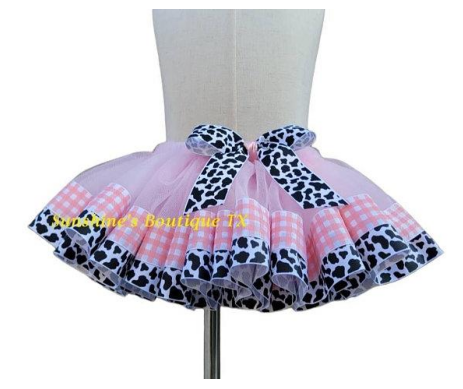

In [ ]:

product_row = df_train[df_train1['product_id'] == 1323699538]

# Display features in a structured way
print("Product ID:", product_row['product_id'].values[0])
print("Title:", product_row['title'].values[0])
print("Description:", product_row['description'].values[0])
print("Tags:", product_row['tags'].values[0])
print("Type:", product_row['type'].values[0])
print("Room:", product_row['room'].values[0])
print("Craft Type:", product_row['craft_type'].values[0])
print("Recipient:", product_row['recipient'].values[0])
print("Material:", product_row['material'].values[0])
print("Occasion:", product_row['occasion'].values[0])
print("Holiday:", product_row['holiday'].values[0])
print("Art Subject:", product_row['art_subject'].values[0])
print("Style:", product_row['style'].values[0])
print("Shape:", product_row['shape'].values[0])
print("Pattern:", product_row['pattern'].values[0])
print("Bottom Category ID:", product_row['bottom_category_id'].values[0])
print("Bottom Category Text:", product_row['bottom_category_text'].values[0])
print("Top Category ID:", product_row['top_category_id'].values[0])
print("Top Category Text:", product_row['top_category_text'].values[0])
print("Primary Color ID:", product_row['primary_color_id'].values[0])
print("Primary Color Text:", product_row['primary_color_text'].values[0])
print("Secondary Color ID:", product_row['secondary_color_id'].values[0])
print("Secondary Color Text:", product_row['secondary_color_text'].values[0])
print("Image Width:", product_row['image/width'].values[0])
print("Image Height:", product_row['image/height'].values[0])

image_bytes = product_row['image/encoded'].values[0]
image = Image.open(io.BytesIO(image_bytes))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:

from scipy.stats import chi2_contingency

# calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# DataFrame with  categorical columns
categorical_columns = ['type', 'room', 'craft_type', 'recipient', 'material',
                       'occasion', 'holiday', 'art_subject', 'style', 'shape',
                       'pattern', 'bottom_category_text', 'top_category_text',
                       'primary_color_text', 'secondary_color_text']
categorical_data = df_train[categorical_columns]

# correlation
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for i, column1 in enumerate(categorical_columns):
    for j, column2 in enumerate(categorical_columns):
        correlation_matrix.loc[column1, column2] = cramers_v(categorical_data[column1], categorical_data[column2])


print("Cramér's V correlation matrix:")
print(correlation_matrix)


Cramér's V correlation matrix:
                          type      room craft_type recipient  material  \
type                       1.0    0.0158   0.081385  0.020634  0.048174   
room                    0.0158       1.0        0.0       0.0  0.071409   
craft_type            0.081385       0.0        1.0       0.0  0.035076   
recipient             0.020634       0.0        0.0       1.0  0.179986   
material              0.048174  0.071409   0.035076  0.179986       1.0   
occasion              0.083215       0.0    0.02489  0.303066  0.013011   
holiday               0.030422  0.020157   0.028312  0.016669  0.023676   
art_subject                0.0   0.17673        0.0       0.0       0.0   
style                      0.0  0.036559   0.028778  0.084389  0.025483   
shape                 0.059617  0.025475        0.0    0.1032  0.225971   
pattern               0.025893       0.0        0.0  0.036241  0.101164   
bottom_category_text  0.556452   0.27289   0.438344  0.284243  0.2961

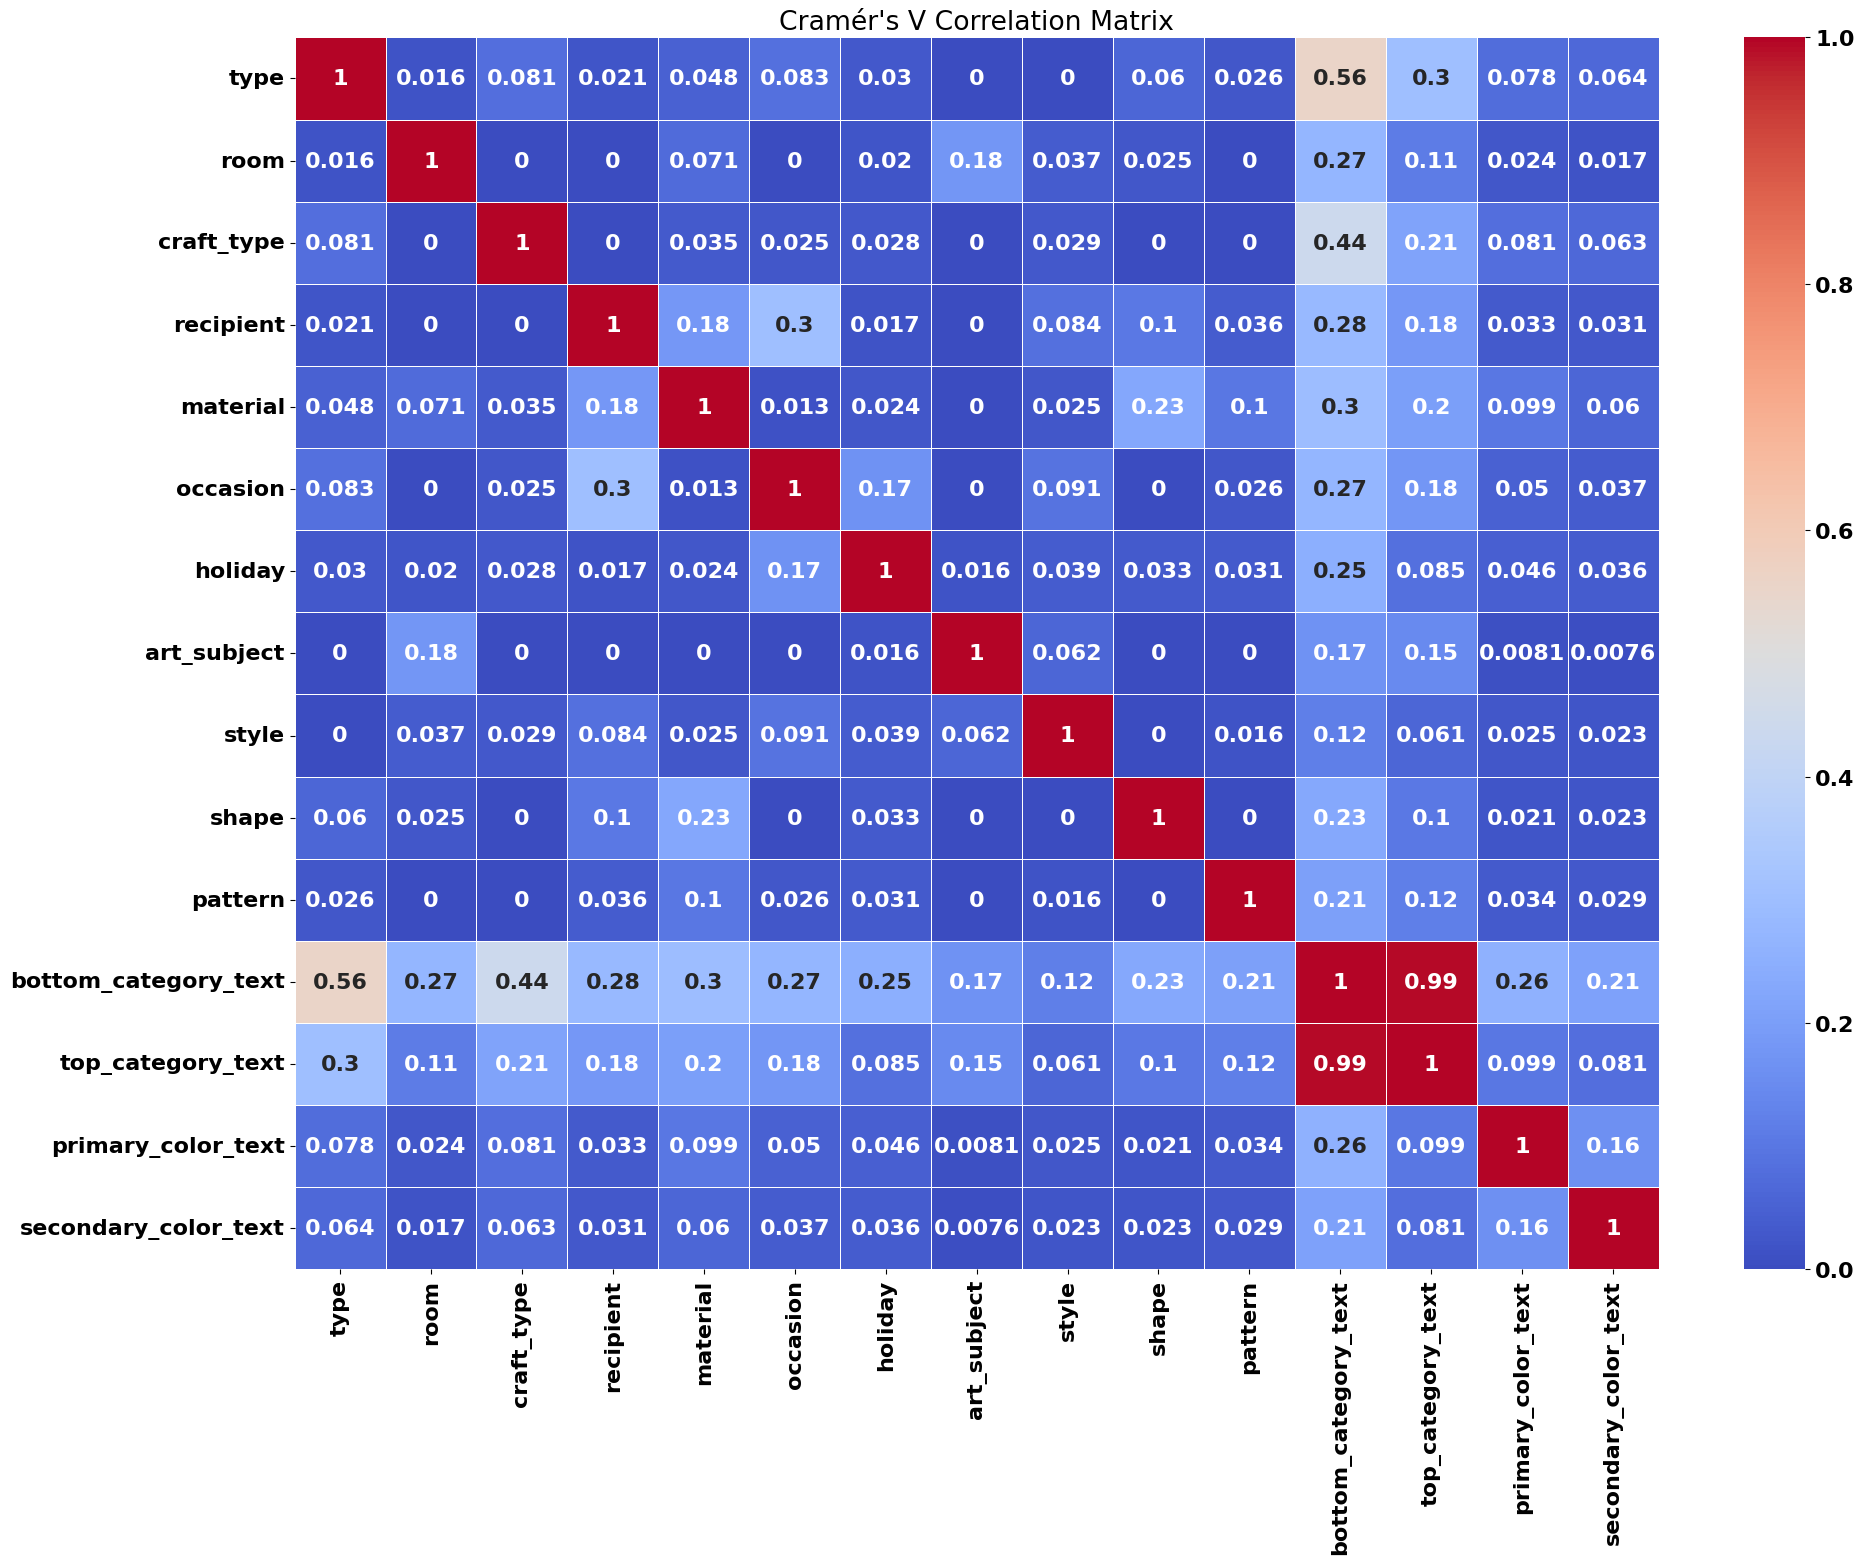

In [ ]:
plt.figure(figsize=(22, 16))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cramér's V Correlation Matrix")
plt.show()

In [ ]:
print("The correlation between 'Type' and 'Bottom Category Text' is relatively high ({:.6f}), suggesting that there may be some association between the type of product and its bottom category.".format(correlation_matrix.loc['type', 'bottom_category_text']))
print("On the other hand, the correlation between 'Craft Type' and 'Room' is very low ({:.1f}), indicating no association between these two variables.".format(correlation_matrix.loc['craft_type', 'room']))


The correlation between 'Type' and 'Bottom Category Text' is relatively high (0.556452), suggesting that there may be some association between the type of product and its bottom category.
On the other hand, the correlation between 'Craft Type' and 'Room' is very low (0.0), indicating no association between these two variables.


In [ ]:
def get_product_info(product_id, df):
    product_info = df[df['product_id'] == product_id][['type', 'bottom_category_text']]
    if not product_info.empty:
        return product_info.iloc[0]
    else:
        return None


product_id = 684071946
product_info = get_product_info(product_id, df_train)

if product_info is not None:
    print("Product ID:", product_id)
    print("Type:", product_info['type'])
    print("Bottom Category Text:", product_info['bottom_category_text'])
else:
    print("Product with ID", product_id, "not found.")


Product ID: 684071946
Type: physical
Bottom Category Text: weddings.clothing.dresses.bridesmaid_dresses


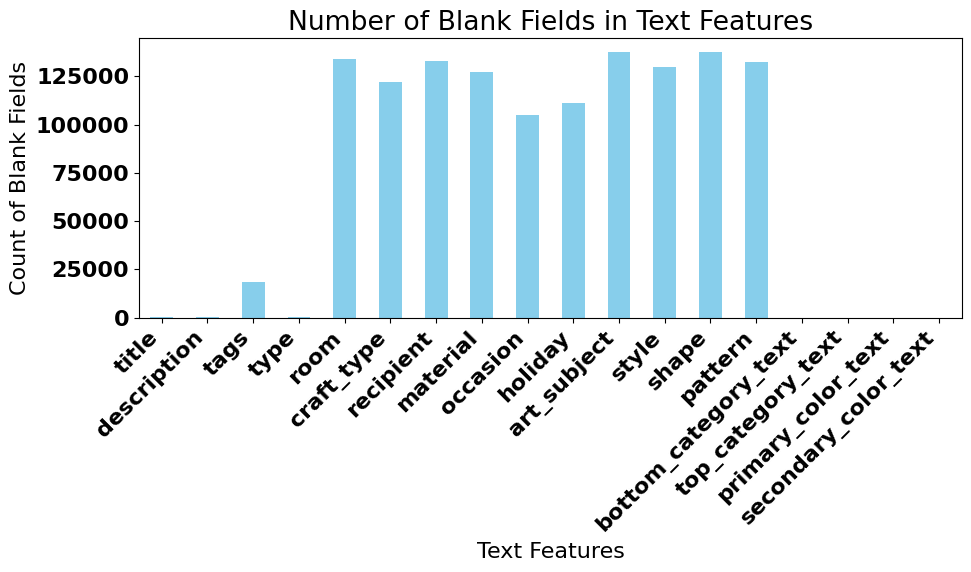

In [ ]:


text_features = ['title', 'description', 'tags', 'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday', 'art_subject', 'style', 'shape', 'pattern', 'bottom_category_text', 'top_category_text', 'primary_color_text', 'secondary_color_text']

# blank fields in text features
blank_counts = df_train[text_features].eq('').sum()


plt.figure(figsize=(10, 6))
blank_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Blank Fields in Text Features')
plt.xlabel('Text Features')
plt.ylabel('Count of Blank Fields')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


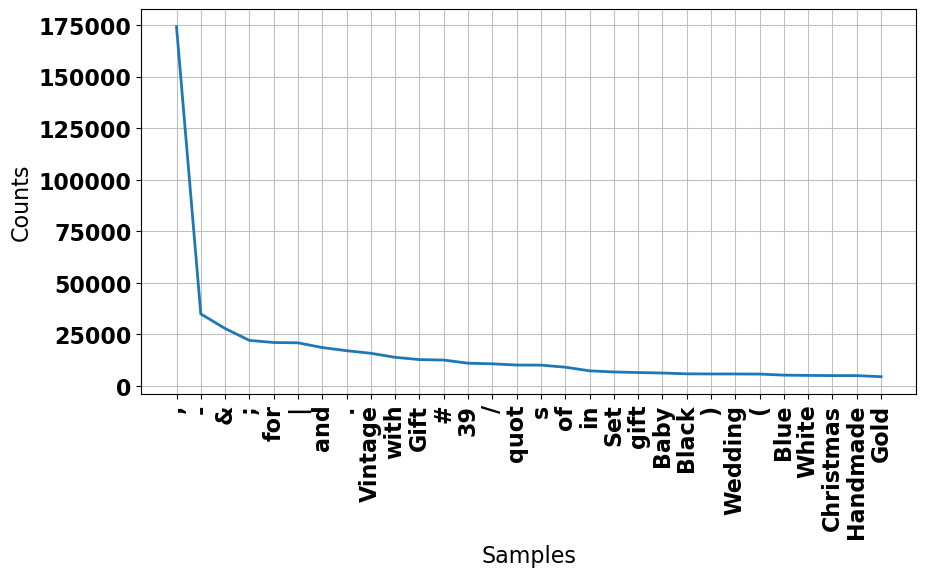

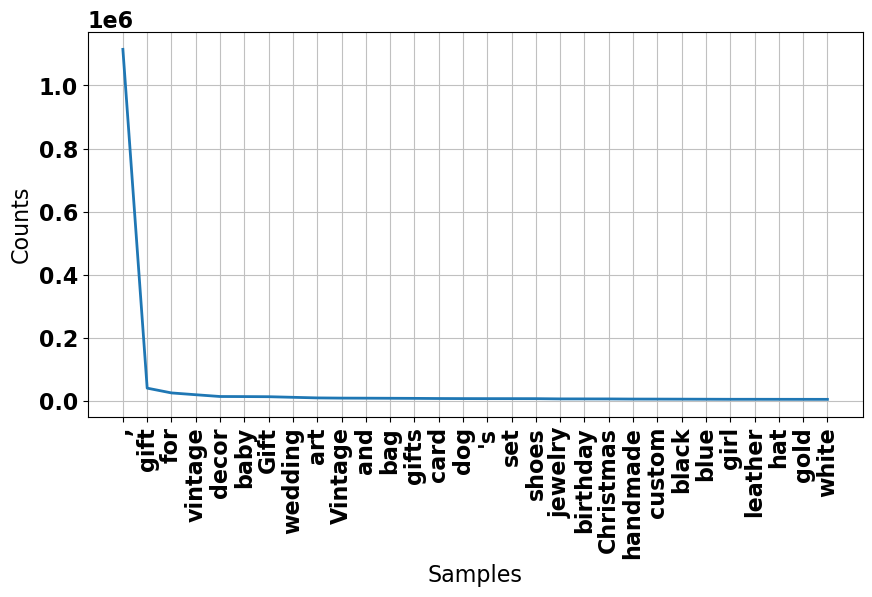

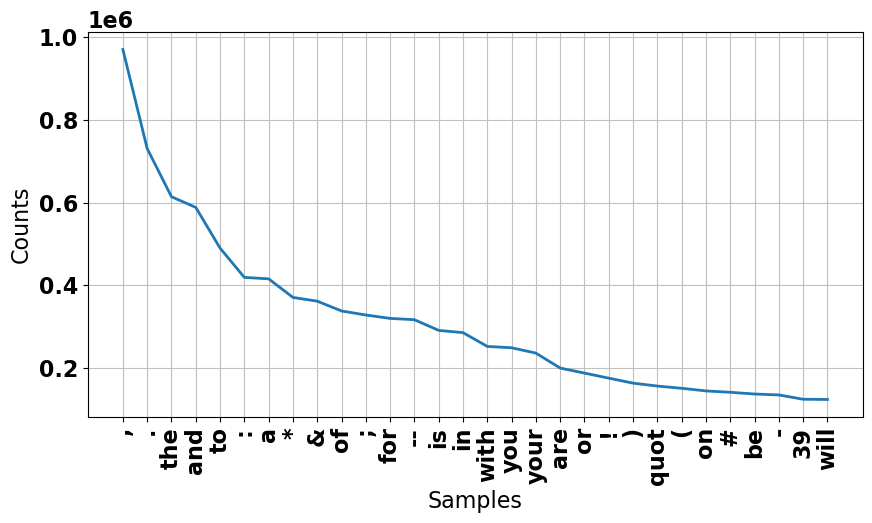

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

def plot_word_frequency(text_column, num_words=30):
    # Tokenization
    tokens = word_tokenize(" ".join(text_column))

    # Word Frequency Analysis
    word_freq = FreqDist(tokens)

    plt.figure(figsize=(10, 5))
    word_freq.plot(num_words, cumulative=False)
    plt.show()


plot_word_frequency(df_train['title'])
plot_word_frequency(df_train['tags'])
plot_word_frequency(df_train['description'])


In [7]:

columns_to_remove = ['product_id','room', 'craft_type', 'recipient', 'material','occasion',
                      'holiday', 'art_subject', 'style', 'shape', 'pattern','primary_color_id','primary_color_text','secondary_color_id',
                     'secondary_color_text','image/encoded','image/width','image/height','bottom_category_id','top_category_id']


df_train_text = df_train.drop(columns=columns_to_remove)

In [8]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65298 entries, 0 to 271
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 65298 non-null  object
 1   description           65298 non-null  object
 2   tags                  65298 non-null  object
 3   type                  65298 non-null  object
 4   bottom_category_text  65298 non-null  object
 5   top_category_text     65298 non-null  object
dtypes: object(6)
memory usage: 3.5+ MB


In [ ]:
df_test_text.head(1)

title  \
0  Vintage Fenton Opalescent Moonstone Hobnail Gl...   

                                         description  \
0  Very pretty vintage Fenton opalescent moonston...   

                                                tags      type  \
0  Fenton perfume,Opalescent bottle,Fenton bottle...  physical   

                                bottom_category_text top_category_text  
0  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses

In [ ]:

df_train_text['type'].fillna('unknown', inplace=True)
df_train_text['tags'].fillna('unknown', inplace=True)

In [ ]:
df_train_text.head(5)

title  \
0  Vintage Fenton Opalescent Moonstone Hobnail Gl...   
1  Vintage 70s perfume bottle with original packa...   
2  Atomiser Spray Bottles 100 ML (Pack of 85) Pla...   
3  Vintage Blue Frosted Glass Round Perfume Bottl...   
4  Vintage 2 Miniature Bottles. Passion for Men f...   

                                         description  \
0  Very pretty vintage Fenton opalescent moonston...   
1  1970s perfume bottle in vintage, new old stock...   
2  You&#39;ve been looking for a plastic spray bo...   
3  Lovely blue frosted swirl glass perfume bottle...   
4  Vintage 2 Miniature Bottles. Passion for Men f...   

                                                tags      type  \
0  Fenton perfume,Opalescent bottle,Fenton bottle...  physical   
1  70s perfume bottle,80s perfume bottle,vintage ...  physical   
2                                Travel Spray Bottle  physical   
3  glass,bottle,bottles,collectible,decor,vintage...  physical   
4  Accessories,Cottage,Shabby Chic,Vanity Jar,Dre...  physical   

                                bottom_category_text top_category_text  
0  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses  
1  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses  
2  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses  
3  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses  
4  bags_and_purses.cosmetic_and_toiletry_storage....   bags_and_purses

In [8]:
import html
import re

def preprocess_text(text):
    # Remove HTML entities
    text = html.unescape(text)
    # Remove commas, semicolons, hashtags, colons, exclamation marks, backslashes, pipes, slashes, newline characters, parentheses, and emojis
    text = re.sub(r'[,\#\:!\\|/\n\(\)\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002639\U00002640\U00002648\U0000264E\U00002B50\U0001F31F]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing
df_train_text['title'] = df_train_text['title'].apply(preprocess_text)
df_train_text['description'] = df_train_text['description'].apply(preprocess_text)
df_train_text['tags'] = df_train_text['tags'].apply(preprocess_text)


df_train_text['type'] = df_train_text['type'].apply(preprocess_text)
df_train_text['bottom_category_text'] = df_train_text['bottom_category_text'].apply(preprocess_text)
df_train_text['top_category_text'] = df_train_text['top_category_text'].apply(preprocess_text)

print(df_train_text.head())


                                               title  \
0  vintage fenton opalescent moonstone hobnail gl...   
1  vintage 70s perfume bottle with original packa...   
2  atomiser spray bottles 100 ml  pack of 85  pla...   
3  vintage blue frosted glass round perfume bottl...   
4  vintage 2 miniature bottles. passion for men f...   

                                         description  \
0  very pretty vintage fenton opalescent moonston...   
1  1970s perfume bottle in vintage  new old stock...   
2  you've been looking for a plastic spray bottle...   
3  lovely blue frosted swirl glass perfume bottle...   
4  vintage 2 miniature bottles. passion for men f...   

                                                tags      type  \
0  fenton perfume opalescent bottle fenton bottle...  physical   
1  70s perfume bottle 80s perfume bottle vintage ...  physical   
2                                travel spray bottle  physical   
3  glass bottle bottles collectible decor vintage...  physical

In [9]:
from sklearn.model_selection import train_test_split


# Split data into features (X) and target (y)
X = df_train_text[['title', 'description', 'tags', 'type', 'top_category_text']]  # Features
y = df_train_text['bottom_category_text']  # Target

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)


Training set shape: (52238, 5) (52238,)
Validation set shape: (13060, 5) (13060,)


In [ ]:
#with just description column

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['description'])
X_train_seq = tokenizer.texts_to_sequences(X_train['description'])
X_val_seq = tokenizer.texts_to_sequences(X_val['description'])

# Pad sequences
max_seq_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_val_seq))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length)

# Encode target labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
num_classes = len(label_encoder.classes_)

# Build CNN model
embedding_dim = 100
num_filters = 128
kernel_size = 5

inputs = Input(shape=(max_seq_length,))
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_seq_length)(inputs)
conv1 = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding)
pool1 = GlobalMaxPooling1D()(conv1)
outputs = Dense(num_classes, activation='softmax')(pool1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_val_pad, y_val_encoded)
print("Validation Accuracy:", accuracy)


Epoch 1/10
817/817 [==============================] - 109s 132ms/step - loss: 5.7930 - accuracy: 0.1029 - val_loss: 3.7228 - val_accuracy: 0.3329
Epoch 2/10
817/817 [==============================] - 64s 78ms/step - loss: 2.4726 - accuracy: 0.5164 - val_loss: 2.1471 - val_accuracy: 0.5592
Epoch 3/10
817/817 [==============================] - 48s 58ms/step - loss: 1.3096 - accuracy: 0.7211 - val_loss: 1.8523 - val_accuracy: 0.6075
Epoch 4/10
817/817 [==============================] - 41s 50ms/step - loss: 0.7354 - accuracy: 0.8477 - val_loss: 1.7884 - val_accuracy: 0.6218
Epoch 5/10
817/817 [==============================] - 36s 44ms/step - loss: 0.3886 - accuracy: 0.9287 - val_loss: 1.8103 - val_accuracy: 0.6290
Epoch 6/10
817/817 [==============================] - 32s 39ms/step - loss: 0.2052 - accuracy: 0.9677 - val_loss: 1.8333 - val_accuracy: 0.6344
Epoch 7/10
817/817 [==============================] - 33s 40ms/step - loss: 0.1220 - accuracy: 0.9825 - val_loss: 1.8811 - val_accurac

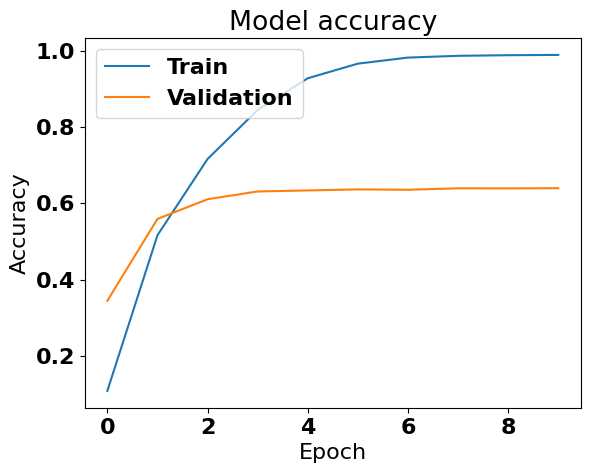

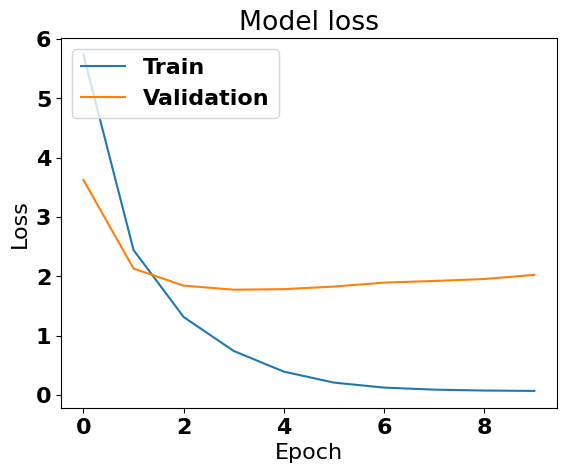

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# using all 4 non null columns of text

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tokenize text data for description
tokenizer_desc = Tokenizer()
tokenizer_desc.fit_on_texts(X_train['description'])
X_train_seq_desc = tokenizer_desc.texts_to_sequences(X_train['description'])
X_val_seq_desc = tokenizer_desc.texts_to_sequences(X_val['description'])

# Tokenize text data for title
tokenizer_title = Tokenizer()
tokenizer_title.fit_on_texts(X_train['title'])
X_train_seq_title = tokenizer_title.texts_to_sequences(X_train['title'])
X_val_seq_title = tokenizer_title.texts_to_sequences(X_val['title'])

# Tokenize text data for tags
tokenizer_tags = Tokenizer()
tokenizer_tags.fit_on_texts(X_train['tags'])
X_train_seq_tags = tokenizer_tags.texts_to_sequences(X_train['tags'])
X_val_seq_tags = tokenizer_tags.texts_to_sequences(X_val['tags'])

# Tokenize text data for type
tokenizer_type = Tokenizer()
tokenizer_type.fit_on_texts(X_train['type'])
X_train_seq_type = tokenizer_type.texts_to_sequences(X_train['type'])
X_val_seq_type = tokenizer_type.texts_to_sequences(X_val['type'])

# Pad sequences
max_seq_length_desc = max(max(len(seq) for seq in X_train_seq_desc), max(len(seq) for seq in X_val_seq_desc))
max_seq_length_title = max(max(len(seq) for seq in X_train_seq_title), max(len(seq) for seq in X_val_seq_title))
max_seq_length_tags = max(max(len(seq) for seq in X_train_seq_tags), max(len(seq) for seq in X_val_seq_tags))
max_seq_length_type = max(max(len(seq) for seq in X_train_seq_type), max(len(seq) for seq in X_val_seq_type))

X_train_pad_desc = pad_sequences(X_train_seq_desc, maxlen=max_seq_length_desc)
X_val_pad_desc = pad_sequences(X_val_seq_desc, maxlen=max_seq_length_desc)

X_train_pad_title = pad_sequences(X_train_seq_title, maxlen=max_seq_length_title)
X_val_pad_title = pad_sequences(X_val_seq_title, maxlen=max_seq_length_title)

X_train_pad_tags = pad_sequences(X_train_seq_tags, maxlen=max_seq_length_tags)
X_val_pad_tags = pad_sequences(X_val_seq_tags, maxlen=max_seq_length_tags)

X_train_pad_type = pad_sequences(X_train_seq_type, maxlen=max_seq_length_type)
X_val_pad_type = pad_sequences(X_val_seq_type, maxlen=max_seq_length_type)

# Concatenate sequences
X_train_pad_concat = np.concatenate((X_train_pad_desc, X_train_pad_title, X_train_pad_tags, X_train_pad_type), axis=1)
X_val_pad_concat = np.concatenate((X_val_pad_desc, X_val_pad_title, X_val_pad_tags, X_val_pad_type), axis=1)

# Encode target labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
num_classes = len(label_encoder.classes_)

In [26]:
X_train_pad_concat.shape[1]


4241

In [27]:
X_val_pad_concat.shape[1]

4241

In [30]:


# Build CNN model
embedding_dim = 200#changed to 100 to 200
num_filters = 256#changed from 126
kernel_size = 5

inputs = Input(shape=(X_train_pad_concat.shape[1],))
embedding = Embedding(input_dim=len(tokenizer_desc.word_index)+1, output_dim=embedding_dim, input_length=X_train_pad_concat.shape[1])(inputs)
conv1 = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding)
pool1 = GlobalMaxPooling1D()(conv1)
outputs = Dense(num_classes, activation='softmax')(pool1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4241)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 4241, 200)         28387600  
                                                                 
 conv1d_3 (Conv1D)           (None, 4237, 256)         256256    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 742)               190694    
                                                                 
Total params: 28834550 (110.00 MB)
Trainable params: 28834550 (110.00 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [11]:


# Build CNN model
embedding_dim = 200#changed to 100 to 200
num_filters = 256#changed from 126
kernel_size = 5

inputs = Input(shape=(X_train_pad_concat.shape[1],))
embedding = Embedding(input_dim=len(tokenizer_desc.word_index)+1, output_dim=embedding_dim, input_length=X_train_pad_concat.shape[1])(inputs)
conv1 = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding)
pool1 = GlobalMaxPooling1D()(conv1)
outputs = Dense(num_classes, activation='softmax')(pool1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad_concat, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_val_pad_concat, y_val_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_val_pad_concat, y_val_encoded)
print("Validation Accuracy:", accuracy)


Epoch 1/10
817/817 [==============================] - 192s 228ms/step - loss: 5.3131 - accuracy: 0.1549 - val_loss: 2.9851 - val_accuracy: 0.4298
Epoch 2/10
817/817 [==============================] - 143s 175ms/step - loss: 1.8841 - accuracy: 0.6117 - val_loss: 1.8678 - val_accuracy: 0.6036
Epoch 3/10
817/817 [==============================] - 132s 161ms/step - loss: 0.7839 - accuracy: 0.8300 - val_loss: 1.7074 - val_accuracy: 0.6354
Epoch 4/10
817/817 [==============================] - 125s 153ms/step - loss: 0.2870 - accuracy: 0.9484 - val_loss: 1.7289 - val_accuracy: 0.6385
Epoch 5/10
817/817 [==============================] - 119s 145ms/step - loss: 0.1095 - accuracy: 0.9843 - val_loss: 1.7211 - val_accuracy: 0.6518
Epoch 6/10
817/817 [==============================] - 116s 143ms/step - loss: 0.0618 - accuracy: 0.9908 - val_loss: 1.7832 - val_accuracy: 0.6502
Epoch 7/10
817/817 [==============================] - 116s 142ms/step - loss: 0.0486 - accuracy: 0.9926 - val_loss: 1.7762 -

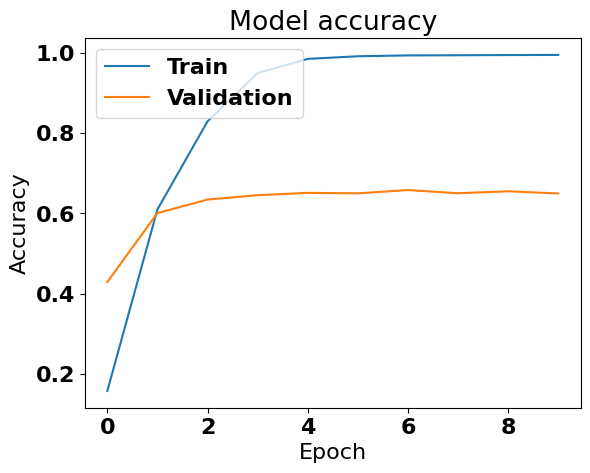

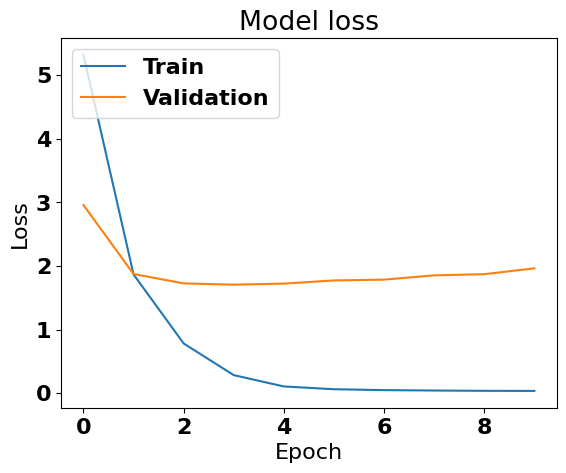

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
# Predict the bottom category for the validation data
y_val_pred_encoded = model.predict(X_val_pad_concat)
y_val_pred = label_encoder.inverse_transform(np.argmax(y_val_pred_encoded, axis=1))

# Compare predicted categories with ground truth categories
comparison_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})
print(comparison_df.head())


409/409 [==============================] - 8s 19ms/step
                                                 Actual  \
853        art_and_collectibles.collectibles.tobacciana   
215     home_and_living.home_improvement.lighting_parts   
734             shoes.insoles_and_accessories.shoehorns   
3759  craft_supplies_and_tools.floral_arranging_supp...   
2768  clothing.girls_clothing.baby_girls_clothing.co...   

                                              Predicted  
853        art_and_collectibles.collectibles.tobacciana  
215     home_and_living.home_improvement.lighting_parts  
734            shoes.insoles_and_accessories.shoe_trees  
3759  craft_supplies_and_tools.floral_arranging_supp...  
2768  clothing.girls_clothing.baby_girls_clothing.co...  


In [ ]:
from tensorflow.keras.layers import Dropout

#  model architecture with dropout regularization
inputs = Input(shape=(X_train_pad_concat.shape[1],))
embedding = Embedding(input_dim=len(tokenizer_desc.word_index)+1, output_dim=embedding_dim, input_length=X_train_pad_concat.shape[1])(inputs)
conv1 = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding)
# Add dropout layer after the convolutional layer
dropout = Dropout(0.5)(conv1)  #  the dropout rate
pool1 = GlobalMaxPooling1D()(dropout)
outputs = Dense(num_classes, activation='softmax')(pool1)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad_concat, y_train_encoded, epochs=5, batch_size=64, validation_data=(X_val_pad_concat, y_val_encoded))


Epoch 1/5
817/817 [==============================] - 166s 201ms/step - loss: 5.5396 - accuracy: 0.1299 - val_loss: 3.8498 - val_accuracy: 0.3849
Epoch 2/5
817/817 [==============================] - 140s 171ms/step - loss: 2.1841 - accuracy: 0.5532 - val_loss: 2.4205 - val_accuracy: 0.5877
Epoch 3/5
817/817 [==============================] - 130s 159ms/step - loss: 1.1011 - accuracy: 0.7499 - val_loss: 2.0355 - val_accuracy: 0.6268
Epoch 4/5
817/817 [==============================] - 125s 153ms/step - loss: 0.5761 - accuracy: 0.8674 - val_loss: 1.8432 - val_accuracy: 0.6475
Epoch 5/5
817/817 [==============================] - 127s 155ms/step - loss: 0.2925 - accuracy: 0.9365 - val_loss: 1.7565 - val_accuracy: 0.6485


In [ ]:
# Predict the bottom category for the validation data
y_val_pred_encoded = model.predict(X_val_pad_concat)
y_val_pred = label_encoder.inverse_transform(np.argmax(y_val_pred_encoded, axis=1))

# Compare predicted categories with ground truth categories
comparison_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})
print(comparison_df.head(10))


409/409 [==============================] - 7s 18ms/step
                                                 Actual  \
853        art_and_collectibles.collectibles.tobacciana   
215     home_and_living.home_improvement.lighting_parts   
734             shoes.insoles_and_accessories.shoehorns   
3759  craft_supplies_and_tools.floral_arranging_supp...   
2768  clothing.girls_clothing.baby_girls_clothing.co...   
36    craft_supplies_and_tools.blanks.hat_and_hair_b...   
1038  paper_and_party_supplies.paper.greeting_cards....   
982      clothing.boys_clothing.baby_boys_clothing.tops   
1375  home_and_living.lighting.lamps_shades_and_base...   
314   home_and_living.outdoor_and_garden.planters_an...   

                                              Predicted  
853        art_and_collectibles.collectibles.tobacciana  
215     home_and_living.home_improvement.lighting_parts  
734             shoes.insoles_and_accessories.shoehorns  
3759  home_and_living.home_decor.wall_decor.wall_han...  
2768

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_val_pred_encoded = model.predict(X_val_pad_concat)
y_val_pred = np.argmax(y_val_pred_encoded, axis=1)

y_val_true = label_encoder.inverse_transform(y_val_encoded)
y_val_pred = label_encoder.inverse_transform(y_val_pred)


precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


409/409 [==============================] - 7s 18ms/step
Precision: 0.6854822764228555
Recall: 0.6496171516079633
F1-score: 0.6537801596889093


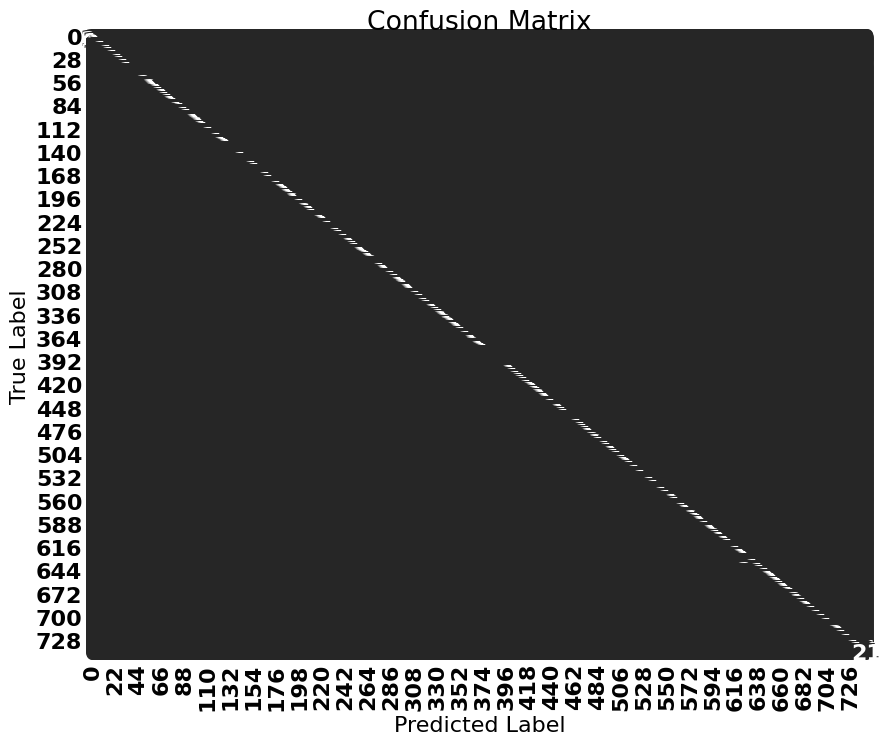

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_val_true, y_val_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#############extracting top category text from predicted bottom category

In [ ]:
print(y_val_pred[2])


shoes.insoles_and_accessories.shoehorns


In [ ]:


# Extract top-level category text prediction from y_val_pred
top_categories = [prediction.split('.')[0] for prediction in y_val_pred]

top_category_text_prediction_df = pd.DataFrame({'Top Category': top_categories})

print(top_category_text_prediction_df.head())


           Top Category
0  art_and_collectibles
1       home_and_living
2                 shoes
3       home_and_living
4              clothing


In [ ]:
# Print all unique top-level categories
unique_top_categories = top_category_text_prediction_df['Top Category'].unique()
print(unique_top_categories)


['art_and_collectibles' 'home_and_living' 'shoes' 'clothing'
 'craft_supplies_and_tools' 'paper_and_party_supplies' 'jewelry'
 'toys_and_games' 'pet_supplies' 'weddings' 'electronics_and_accessories'
 'bath_and_beauty' 'books_movies_and_music' 'bags_and_purses'
 'accessories']


In [ ]:
df_train['top_category_text'].unique()

array(['bags_and_purses', 'craft_supplies_and_tools', 'home_and_living',
       'clothing', 'weddings', 'paper_and_party_supplies',
       'bath_and_beauty', 'toys_and_games', 'shoes', 'accessories',
       'pet_supplies', 'books_movies_and_music', 'jewelry',
       'art_and_collectibles', 'electronics_and_accessories'],
      dtype=object)

In [ ]:
# Check if both outputs are matching
matching = all(elem in unique_top_categories for elem in df_train['top_category_text'].unique()) and all(elem in df_train['top_category_text'].unique() for elem in unique_top_categories)
print("Outputs matching:", matching)


Outputs matching: True


In [18]:

# Extract top-level category text prediction from y_val_pred
top_categories = [prediction.split('.')[0] for prediction in y_val_pred]
bottom_categories = y_val_pred

prediction_df = pd.DataFrame({'Top Category Prediction': top_categories, 'Bottom Category Prediction': bottom_categories})


predicted_top_category_data = []
predicted_bottom_category_data = []

# Match and extract top category IDs
for index, row in df_train.iterrows():
    if row['top_category_text'] in prediction_df['Top Category Prediction'].values:
        top_category_id = row['top_category_id']
        top_category_text = row['top_category_text']
        predicted_top_category_data.append({'Top Category Text': top_category_text, 'Top Category ID': top_category_id})

# Match and extract bottom category IDs
for index, row in df_train.iterrows():
    if row['bottom_category_text'] in prediction_df['Bottom Category Prediction'].values:
        bottom_category_id = row['bottom_category_id']
        bottom_category_text = row['bottom_category_text']
        predicted_bottom_category_data.append({'Bottom Category Text': bottom_category_text, 'Bottom Category ID': bottom_category_id})

predicted_top_category_df = pd.DataFrame(predicted_top_category_data)
predicted_bottom_category_df = pd.DataFrame(predicted_bottom_category_data)

print(predicted_top_category_df.head())
print(predicted_bottom_category_df.head())


  Top Category Text  Top Category ID
0   bags_and_purses                2
1   bags_and_purses                2
2   bags_and_purses                2
3   bags_and_purses                2
4   bags_and_purses                2
                                Bottom Category Text  Bottom Category ID
0  bags_and_purses.cosmetic_and_toiletry_storage....                2160
1  bags_and_purses.cosmetic_and_toiletry_storage....                2160
2  bags_and_purses.cosmetic_and_toiletry_storage....                2160
3  bags_and_purses.cosmetic_and_toiletry_storage....                2160
4  bags_and_purses.cosmetic_and_toiletry_storage....                2160


In [19]:

text_prediction_df_23265772 = pd.merge(predicted_top_category_df, predicted_bottom_category_df, left_index=True, right_index=True)


print(text_prediction_df_23265772.head())

text_prediction_df_23265772.to_parquet('text_prediction_df_23265772.parquet')


  Top Category Text  Top Category ID  \
0   bags_and_purses                2   
1   bags_and_purses                2   
2   bags_and_purses                2   
3   bags_and_purses                2   
4   bags_and_purses                2   

                                Bottom Category Text  Bottom Category ID  
0  bags_and_purses.cosmetic_and_toiletry_storage....                2160  
1  bags_and_purses.cosmetic_and_toiletry_storage....                2160  
2  bags_and_purses.cosmetic_and_toiletry_storage....                2160  
3  bags_and_purses.cosmetic_and_toiletry_storage....                2160  
4  bags_and_purses.cosmetic_and_toiletry_storage....                2160  


In [ ]:
#############################iMAGE

In [34]:
# Extract image relevant columns
df_train_image = df_train[['primary_color_id', 'primary_color_text', 'secondary_color_id', 'secondary_color_text', 'image/encoded', 'image/width', 'image/height']]
print(df_train_image.iloc[0])


primary_color_id                                                        5
primary_color_text                                                  clear
secondary_color_id                                                     17
secondary_color_text                                                white
image/encoded           b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
image/width                                                           570
image/height                                                          817
Name: 0, dtype: object


In [35]:
df_train_image.shape

(65298, 7)

In [38]:
df_train_image_half = df_train_image.iloc[:len(df_train_image)//50]


In [39]:
df_train_image_half.shape

(1305, 7)

In [ ]:
df_train_image_half.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6529 entries, 0 to 305
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   primary_color_id      6529 non-null   int64 
 1   primary_color_text    6529 non-null   object
 2   secondary_color_id    6529 non-null   int64 
 3   secondary_color_text  6529 non-null   object
 4   image/encoded         6529 non-null   object
 5   image/width           6529 non-null   int64 
 6   image/height          6529 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 408.1+ KB


In [ ]:
df_train_image_half.iloc[0]

primary_color_id                                                        5
primary_color_text                                                  clear
secondary_color_id                                                     17
secondary_color_text                                                white
image/encoded           b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
image/width                                                           570
image/height                                                          817
Name: 0, dtype: object

In [ ]:
df_train_image_half['primary_color_text'].value_counts()

primary_color_text
white        916
black        722
blue         717
pink         573
brown        559
red          535
green        426
beige        395
silver       286
other        281
yellow       206
gold         198
purple       184
orange       148
rainbow      124
clear        117
bronze        80
copper        43
rose gold     19
Name: count, dtype: int64

In [ ]:
df_train_image_half['secondary_color_text'].value_counts()

secondary_color_text
white        1044
black         884
blue          501
green         465
brown         457
pink          437
red           436
gold          391
beige         310
silver        306
yellow        264
other         261
orange        204
rainbow       166
purple        139
bronze         84
clear          79
copper         61
rose gold      40
Name: count, dtype: int64

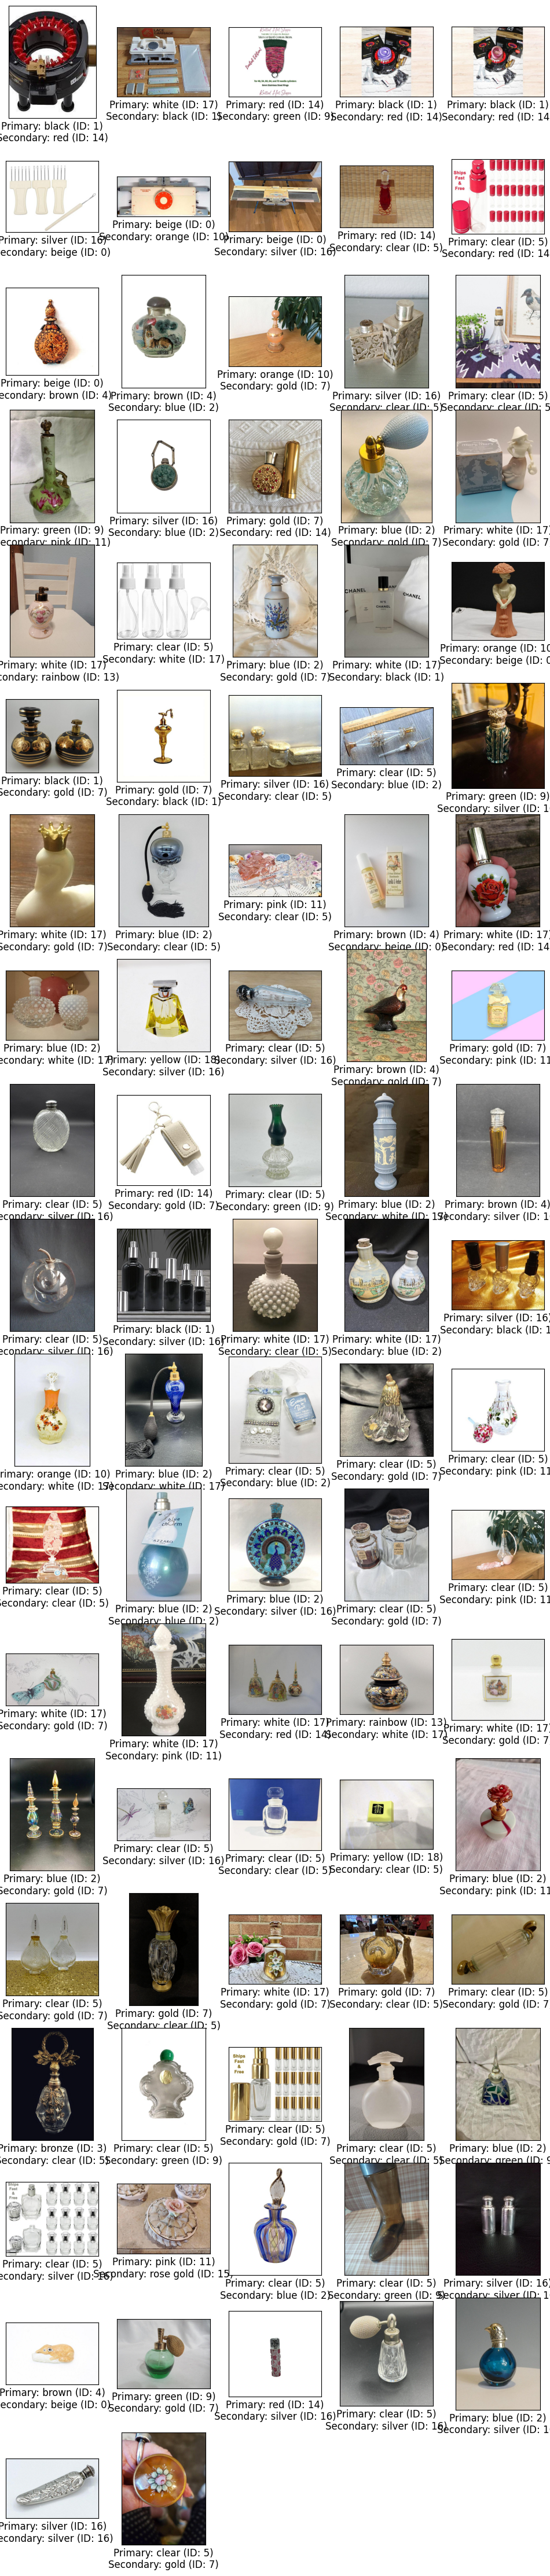

In [ ]:
import io
from PIL import Image
import matplotlib.pyplot as plt

def show_images(dataframe, N=100):

    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows

    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():

        ax = plt.subplot(num_rows, num_cols, i + 1)

        img_bytes = row["image/encoded"]
        primary_color_id = row["primary_color_id"]
        primary_color_text = row["primary_color_text"]
        secondary_color_id = row["secondary_color_id"]
        secondary_color_text = row["secondary_color_text"]

        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)

        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(f'Primary: {primary_color_text} (ID: {primary_color_id})\nSecondary: {secondary_color_text} (ID: {secondary_color_id})', fontsize=12)
    plt.show()

show_images(df_train_image_half)


In [ ]:
df_train_image_half.isnull().any()

bottom_category_id      False
primary_color_id        False
primary_color_text      False
secondary_color_id      False
secondary_color_text    False
image/encoded           False
image/width             False
image/height            False
dtype: bool

In [ ]:
#Extracting feature then image classification

In [40]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# preprocessing functions
def decode_image(encoded_image):
    decoded_image = np.frombuffer(encoded_image, dtype=np.uint8)
    decoded_image = cv2.imdecode(decoded_image, cv2.IMREAD_COLOR)
    return decoded_image

def normalize_image(image):
    return image / 255.0

def resize_image(image, target_height, target_width):
    return cv2.resize(image, (target_height, target_width))

# Load the pre-trained ResNet50 model
def load_resnet50_model():
    return ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Perform object detection or feature extraction using ResNet50
def extract_features(image, resnet_model):

    image = cv2.resize(image, (200, 200))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)

    # Extract features using ResNet50
    features = resnet_model.predict(image)
    return features





In [41]:

def calculate_primary_color(image):
    # Convert image to 8-bit unsigned integer format
    image = cv2.convertScaleAbs(image)

    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate histogram
    hist = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])

    # Find the primary color index (bin with the highest count)
    primary_color_index = np.argmax(hist)

    # Convert index to primary color value
    primary_color = [primary_color_index, 255, 255]

    # Convert primary color from HSV to BGR
    primary_color_bgr = cv2.cvtColor(np.uint8([[primary_color]]), cv2.COLOR_HSV2BGR)[0][0]

    return primary_color_bgr



# Preprocess the image data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_train_image_half['decoded_image'] = df_train_image_half['image/encoded'].apply(decode_image)
    df_train_image_half['normalized_image'] = df_train_image_half['decoded_image'].apply(normalize_image)

    # pre-trained ResNet50 model
    resnet_model = load_resnet50_model()

    # Extract features using ResNet50 and calculate primary colors
    features = []
    primary_colors = []
    for image in df_train_image_half['normalized_image']:
        feature = extract_features(image, resnet_model)
        features.append(feature)
        primary_color = calculate_primary_color(image)
        primary_colors.append(primary_color)

    # Create feature matrix X and target labels y for primary color classification
    X = np.array(features).reshape(len(features), -1)
    y = df_train_image_half['primary_color_id']


    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

1/1 [==============================] - 0s 24ms/step


In [42]:

    model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')  #  20 output neurons for 20 primary colors
])


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    model.summary()

Epoch 1/10
29/29 [==============================] - 3s 32ms/step - loss: 8.9373 - accuracy: 0.0767 - val_loss: 2.9363 - val_accuracy: 0.0612
Epoch 2/10
29/29 [==============================] - 1s 22ms/step - loss: 2.9992 - accuracy: 0.1117 - val_loss: 2.9569 - val_accuracy: 0.1403
Epoch 3/10
29/29 [==============================] - 1s 21ms/step - loss: 2.9397 - accuracy: 0.1490 - val_loss: 2.9193 - val_accuracy: 0.1403
Epoch 4/10
29/29 [==============================] - 1s 21ms/step - loss: 2.9009 - accuracy: 0.1435 - val_loss: 2.8824 - val_accuracy: 0.1531
Epoch 5/10
29/29 [==============================] - 1s 21ms/step - loss: 2.8666 - accuracy: 0.1599 - val_loss: 2.8462 - val_accuracy: 0.1531
Epoch 6/10
29/29 [==============================] - 1s 22ms/step - loss: 2.8284 - accuracy: 0.1512 - val_loss: 2.8093 - val_accuracy: 0.1531
Epoch 7/10
29/29 [==============================] - 1s 21ms/step - loss: 2.7957 - accuracy: 0.1566 - val_loss: 2.7751 - val_accuracy: 0.1531
Epoch 8/10
29

In [18]:

    model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')  # Assuming 20 output neurons for 20 primary colors
])


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Evaluate the model
    model.evaluate(X_val, y_val)


Epoch 1/10
64/64 [==============================] - 3s 28ms/step - loss: 6.1063 - accuracy: 0.0932 - val_loss: 2.8965 - val_accuracy: 0.1029
Epoch 2/10
64/64 [==============================] - 1s 21ms/step - loss: 2.9258 - accuracy: 0.1236 - val_loss: 2.8722 - val_accuracy: 0.1040
Epoch 3/10
64/64 [==============================] - 1s 21ms/step - loss: 2.8369 - accuracy: 0.1094 - val_loss: 2.7961 - val_accuracy: 0.1063
Epoch 4/10
64/64 [==============================] - 1s 21ms/step - loss: 2.7728 - accuracy: 0.1241 - val_loss: 2.7274 - val_accuracy: 0.1051
Epoch 5/10
64/64 [==============================] - 1s 21ms/step - loss: 2.7296 - accuracy: 0.1231 - val_loss: 2.6881 - val_accuracy: 0.1051
Epoch 6/10
64/64 [==============================] - 1s 21ms/step - loss: 2.7089 - accuracy: 0.1187 - val_loss: 2.6731 - val_accuracy: 0.1131
Epoch 7/10
64/64 [==============================] - 1s 21ms/step - loss: 2.7072 - accuracy: 0.1187 - val_loss: 2.6660 - val_accuracy: 0.1131
Epoch 8/10
64

[2.6610782146453857, 0.1120000034570694]

In [ ]:
##########used only 2k images

In [ ]:
#################just primary color detection

In [9]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Load images and preprocess
image_list = []
primary_color_labels = []
for img_data, primary_color_id in zip(df_train_image_half['image/encoded'], df_train_image_half['primary_color_id']):
    # Convert binary image data to image array
    img = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)  # Decode image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to the input size
    img = img.astype("float32") / 255.0  # Normalize pixel values
    image_list.append(img)
    primary_color_labels.append(primary_color_id)

X_images = np.array(image_list)
# Convert primary_color_labels to a NumPy array
primary_color_labels = np.array(primary_color_labels)

y_primary_color = to_categorical(primary_color_labels, num_classes=20)  # there are 20 primary colors



# Split data into train and validation sets
X_train_images, X_val_images, y_train_primary, y_val_primary = train_test_split(
    X_images, y_primary_color, test_size=0.2, random_state=42)


In [10]:
# the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax')  # 20 output classes for primary colors
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [11]:
# Train the model
history = model.fit(X_train_images, y_train_primary,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val_images, y_val_primary))


Epoch 1/10
164/164 [==============================] - 16s 54ms/step - loss: 2.5860 - accuracy: 0.2033 - val_loss: 2.4320 - val_accuracy: 0.2841
Epoch 2/10
164/164 [==============================] - 6s 39ms/step - loss: 2.3491 - accuracy: 0.3084 - val_loss: 2.2971 - val_accuracy: 0.3247
Epoch 3/10
164/164 [==============================] - 6s 39ms/step - loss: 2.2002 - accuracy: 0.3421 - val_loss: 2.1559 - val_accuracy: 0.3714
Epoch 4/10
164/164 [==============================] - 6s 39ms/step - loss: 2.0582 - accuracy: 0.3768 - val_loss: 2.1577 - val_accuracy: 0.3798
Epoch 5/10
164/164 [==============================] - 6s 39ms/step - loss: 1.8759 - accuracy: 0.4206 - val_loss: 2.1591 - val_accuracy: 0.3867
Epoch 6/10
164/164 [==============================] - 6s 39ms/step - loss: 1.6624 - accuracy: 0.4823 - val_loss: 2.3554 - val_accuracy: 0.3660
Epoch 7/10
164/164 [==============================] - 6s 39ms/step - loss: 1.3814 - accuracy: 0.5663 - val_loss: 2.5499 - val_accuracy: 0.362

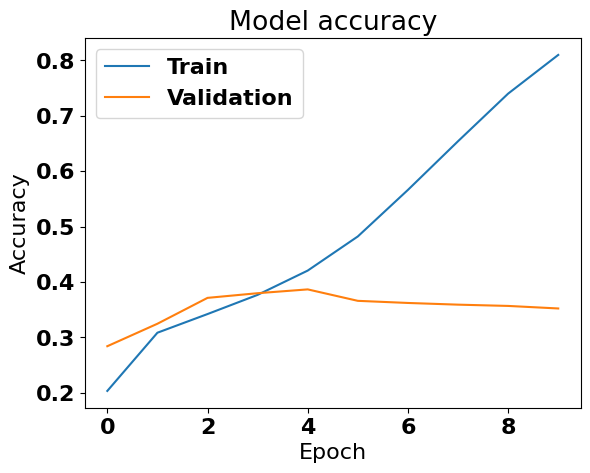

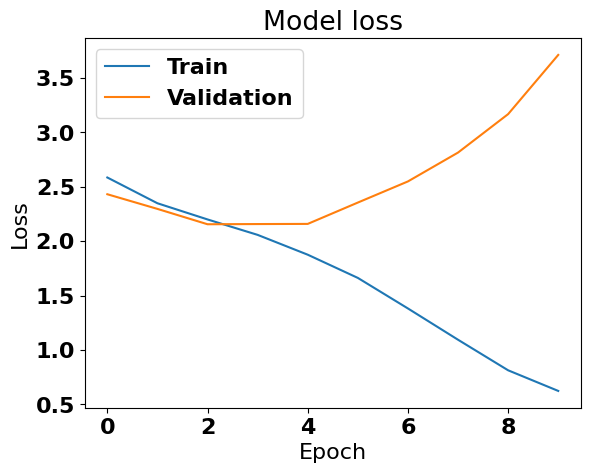

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
import warnings
from sklearn.metrics import classification_report

# Filter out warnings
warnings.filterwarnings("ignore")

# Get predictions on the validation set
y_pred = model.predict(X_val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_primary, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)

# Reset warnings to default behavior
warnings.resetwarnings()


41/41 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.18      0.25      0.21        76
           1       0.43      0.52      0.47       139
           2       0.46      0.48      0.47       141
           3       0.00      0.00      0.00        13
           4       0.26      0.27      0.26       107
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00         9
           7       0.27      0.16      0.20        45
           9       0.42      0.25      0.31        80
          10       0.00      0.00      0.00        34
          11       0.43      0.38      0.40       112
          12       0.46      0.34      0.39        47
          13       0.00      0.00      0.00        25
          14       0.42      0.61      0.50       115
          15       0.00      0.00      0.00         2
          16       0.20      0.22      0.21        60
          17       0.37    

In [ ]:
#adding more layers

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax')  # 20 output classes for primary colors
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show summary of the model
model.summary()

# Train the model
history = model.fit(X_train_images, y_train_primary,
                    batch_size=64,
                    epochs=13,
                    validation_data=(X_val_images, y_val_primary))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

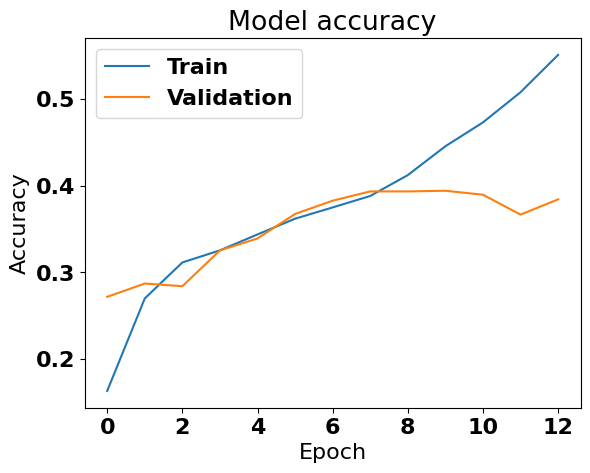

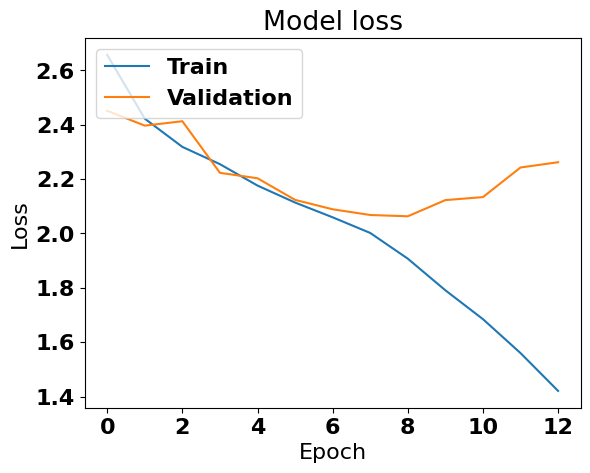

In [16]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import warnings
from sklearn.metrics import classification_report

# Filter out warnings
warnings.filterwarnings("ignore")

# Get predictions on the validation set
y_pred = model.predict(X_val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_primary, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)

# Reset warnings to default behavior
warnings.resetwarnings()


41/41 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.22      0.22      0.22        76
           1       0.46      0.52      0.49       139
           2       0.50      0.50      0.50       141
           3       0.00      0.00      0.00        13
           4       0.34      0.25      0.29       107
           5       0.12      0.08      0.10        25
           6       0.00      0.00      0.00         9
           7       0.33      0.09      0.14        45
           9       0.39      0.55      0.45        80
          10       0.11      0.12      0.12        34
          11       0.44      0.46      0.45       112
          12       0.63      0.26      0.36        47
          13       0.17      0.16      0.17        25
          14       0.50      0.56      0.53       115
          15       0.00      0.00      0.00         2
          16       0.29      0.17      0.21        60
          17       0.40    

In [ ]:
#Resnet50

In [21]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Load images and preprocess
image_list = []
for img_data in df_train_image_half['image/encoded']:
    # Convert binary image data to image array
    img = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)  # Decode image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to the input size expected by ResNet50
    img = img.astype("float32") / 255.0  # Normalize pixel values
    image_list.append(img)

X_images = np.array(image_list)

# Encode categorical variables (primary color and secondary color)
y_primary = to_categorical(df_train_image_half['primary_color_id'] , num_classes=20)
y_secondary = to_categorical(df_train_image_half['secondary_color_id'] , num_classes=20)


# Split data into train and validation sets
X_train_images, X_val_images, y_train_primary, y_val_primary, y_train_secondary, y_val_secondary = train_test_split(
    X_images, y_primary, y_secondary, test_size=0.2, random_state=42)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model (without including top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(256, activation='relu')(x)  # Dense layer with ReLU activation
predictions = Dense(20, activation='softmax')(x)  # Output layer with softmax activation

# Combine base model and custom classification head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [23]:

# Train the model
history = model.fit(X_train_images, y_train_primary,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val_images, y_val_primary))

Epoch 1/10
164/164 [==============================] - 19s 87ms/step - loss: 2.7137 - accuracy: 0.1319 - val_loss: 2.6736 - val_accuracy: 0.1570
Epoch 2/10
164/164 [==============================] - 11s 66ms/step - loss: 2.6429 - accuracy: 0.1543 - val_loss: 2.6896 - val_accuracy: 0.1317
Epoch 3/10
164/164 [==============================] - 11s 66ms/step - loss: 2.6234 - accuracy: 0.1585 - val_loss: 2.6813 - val_accuracy: 0.1462
Epoch 4/10
164/164 [==============================] - 11s 66ms/step - loss: 2.6102 - accuracy: 0.1650 - val_loss: 2.6653 - val_accuracy: 0.1493
Epoch 5/10
164/164 [==============================] - 11s 66ms/step - loss: 2.6012 - accuracy: 0.1639 - val_loss: 2.6584 - val_accuracy: 0.1623
Epoch 6/10
164/164 [==============================] - 11s 66ms/step - loss: 2.5885 - accuracy: 0.1700 - val_loss: 2.6368 - val_accuracy: 0.1662
Epoch 7/10
164/164 [==============================] - 11s 66ms/step - loss: 2.5857 - accuracy: 0.1731 - val_loss: 2.6329 - val_accuracy:

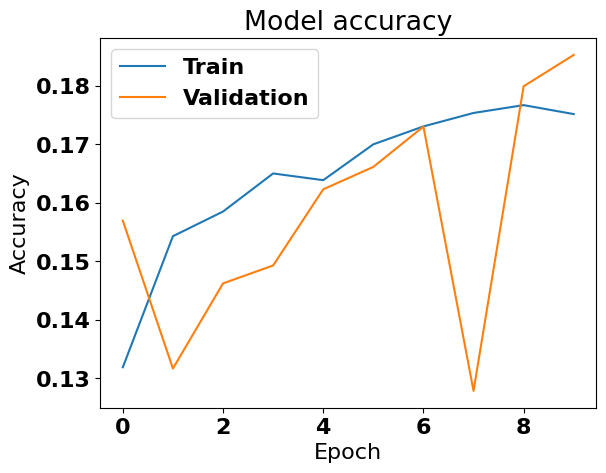

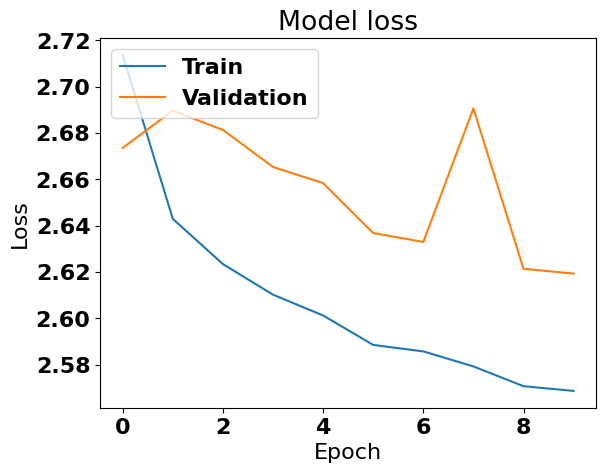

In [24]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
import warnings
from sklearn.metrics import classification_report


warnings.filterwarnings("ignore")

# Get predictions on the validation set
y_pred = model.predict(X_val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_primary, axis=1)


report = classification_report(y_true, y_pred_classes)
print(report)


warnings.resetwarnings()


41/41 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.22      0.35      0.27       139
           2       0.00      0.00      0.00       141
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        80
          10       0.00      0.00      0.00        34
          11       0.14      0.22      0.17       112
          12       0.00      0.00      0.00        47
          13       0.00      0.00      0.00        25
          14       0.22      0.32      0.26       115
          15       0.00      0.00      0.00         2
          16       0.57      0.07      0.12        60
          17       0.18    

In [ ]:
#VGG16

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from sklearn.cluster import KMeans


def decode_image(encoded_image):
    decoded_image = np.frombuffer(encoded_image, dtype=np.uint8)
    decoded_image = cv2.imdecode(decoded_image, cv2.IMREAD_COLOR)
    return decoded_image

def normalize_image(image):
    return image / 255.0

def resize_image(image, target_height, target_width):
    return cv2.resize(image, (target_height, target_width))


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_train_image_half['decoded_image'] = df_train_image_half['image/encoded'].apply(decode_image)
    df_train_image_half['normalized_image'] = df_train_image_half['decoded_image'].apply(normalize_image)

    target_height = 200
    target_width = 200
    df_train_image_half['resized_image'] = df_train_image_half['normalized_image'].apply(lambda x: resize_image(x, target_height, target_width))


    X = np.stack(df_train_image_half['resized_image'].values)
    y = df_train_image_half['primary_color_id']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # Data Augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(X_train)

    # Implement Transfer Learning with a pre-trained model
    base_model = tf.keras.applications.VGG16(input_shape=(target_height, target_width, 3),
                                             include_top=False,
                                             weights='imagenet')
    base_model.trainable = False  # Freeze pre-trained layers

    # Add custom layers on top of the pre-trained model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
        tf.keras.layers.Dense(20, activation='softmax')  # 20 output neurons for 20 predefined colors
    ])

    # Compile the model with a learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    # Train the model
    model.fit(datagen.flow(X_train, y_train, batch_size=32),
              steps_per_epoch=len(X_train) / 32,
              epochs=10,
              validation_data=(X_val, y_val))

    # Evaluate the model
    model.evaluate(X_val, y_val)


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display classification report
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
print(classification_report(y_val, y_pred_classes, target_names=class_names))


1/1 [==============================] - 0s 146ms/step
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         1
     Class 1       0.40      0.67      0.50         3
     Class 2       0.00      0.00      0.00         4
     Class 3       0.00      0.00      0.00         2
     Class 4       0.22      1.00      0.36         4
     Class 5       0.00      0.00      0.00         1
     Class 6       0.00      0.00      0.00         1
     Class 7       0.00      0.00      0.00         3
     Class 8       0.67      0.33      0.44         6
     Class 9       0.00      0.00      0.00         1

    accuracy                           0.31        26
   macro avg       0.13      0.20      0.13        26
weighted avg       0.23      0.31      0.22        26



In [ ]:
#####Ignore below

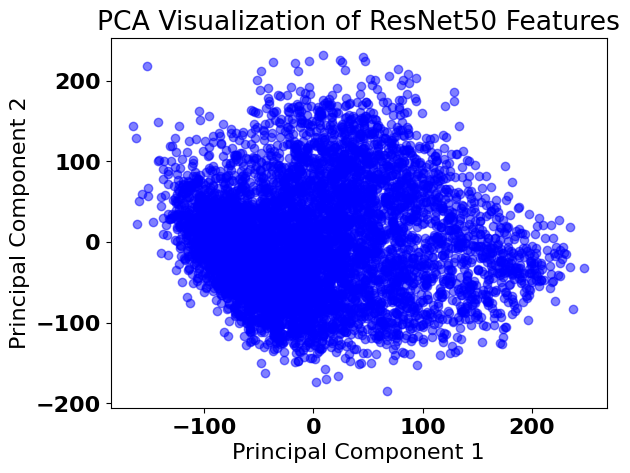

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


X_resnet_flattened = X_resnet_features.reshape(X_resnet_features.shape[0], -1)


pca = PCA(n_components=2)
X_resnet_features_pca = pca.fit_transform(X_resnet_flattened)


plt.scatter(X_resnet_features_pca[:, 0], X_resnet_features_pca[:, 1], c='blue', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of ResNet50 Features')
plt.show()


In [ ]:
###############Base line provided

In [ ]:
df_train['type'].value_counts(dropna=False)

type
physical    32945
download     1430
               62
Name: count, dtype: int64

In [ ]:
COLORS = df_train['primary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of primary colors in train: {NUM_COLORS:,}"

'Number of primary colors in train: 19'

In [ ]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

C:\Users\pranj\AppData\Local\Temp\ipykernel_9780\1076920215.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


top_category_text
home_and_living                28669
craft_supplies_and_tools       16502
clothing                       15455
toys_and_games                  7829
accessories                     6863
paper_and_party_supplies        6422
bath_and_beauty                 6207
weddings                        4916
art_and_collectibles            4783
jewelry                         4465
shoes                           4213
electronics_and_accessories     3998
books_movies_and_music          3816
bags_and_purses                 2890
pet_supplies                    2825
Name: count, dtype: int64

In [ ]:
df_train['top_category_text'].unique

NameError: name 'df_train' is not defined

C:\Users\pranj\AppData\Local\Temp\ipykernel_9780\3624248663.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


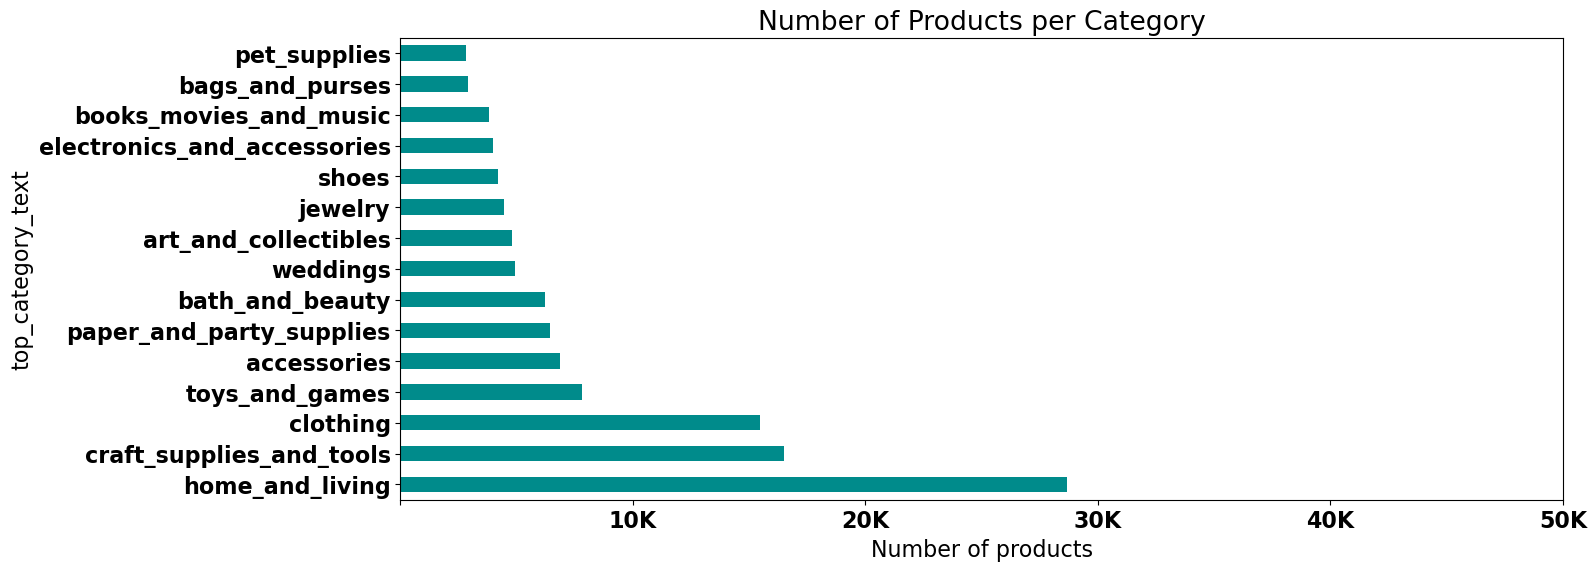

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 1,395'

In [ ]:
def show_images(dataframe, N=100):

    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows

    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row["top_category_text"] if "top_category_text" in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

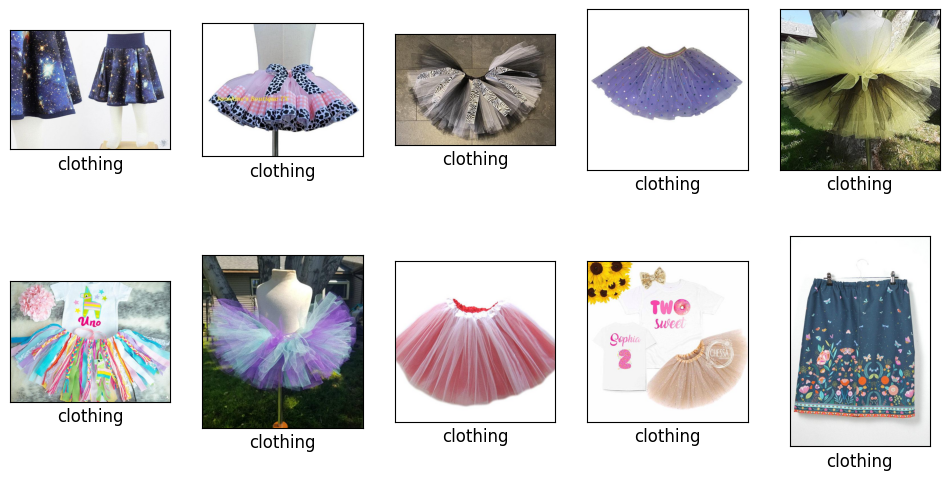

In [ ]:
show_images(df_train, 10)

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [ ]:
df_test = read_data("test", parquet_filenames_test)

In [ ]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'image/encoded',
 'image/width',
 'image/height']

In [ ]:
df_test.iloc[0]

product_id                                               661373440
title            Classroom Valentine Favors, Valentine Pencils,...
description      Valentine Favors, Robots of Love Vinyl Pencil ...
tags             Valentines day favor,kindergarten treats,valen...
type                                                      physical
room                                                              
craft_type                                            kids' crafts
recipient                                                         
material                                                          
occasion                                                          
holiday                                            valentine's day
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

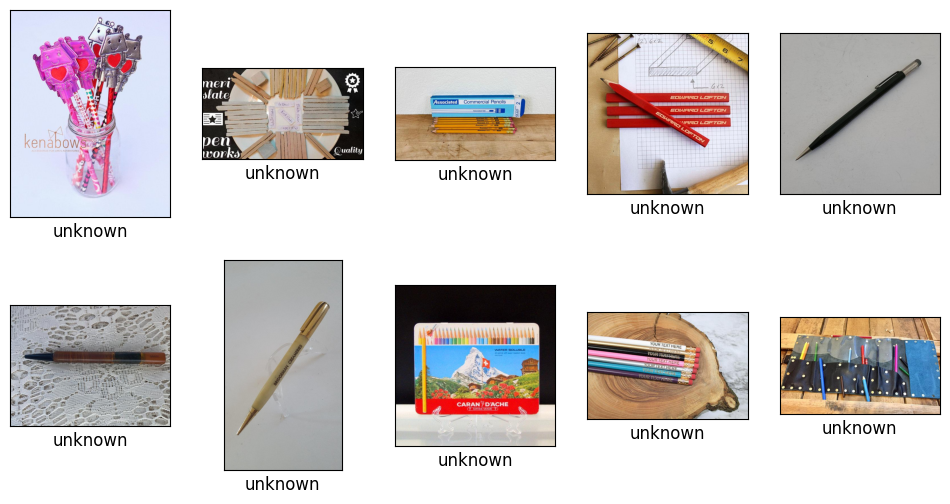

In [ ]:
show_images(df_test, 10)

In [ ]:
######################################################################################

In [ ]:
df_train1 = df_train.iloc[:len(df_train)//10]

In [ ]:
df_train1.shape


(6529, 26)

In [ ]:
df_train1.iloc[0]

product_id                                                     1411933673
title                   Vintage Fenton Opalescent Moonstone Hobnail Gl...
description             Very pretty vintage Fenton opalescent moonston...
tags                    Fenton perfume,Opalescent bottle,Fenton bottle...
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train1,
    test_size=0.1,
    stratify=df_train1['bottom_category_text'],
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 5,876'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 653'

In [ ]:
df_training['bottom_category_text'].value_counts()

bottom_category_text
bath_and_beauty.personal_care.shaving_and_grooming.beard_and_mustache.combs                                             85
clothing.gender_neutral_kids_clothing.gender_neutral_baby_clothing.bloomers_diaper_covers_and_underwear.bloomers        85
clothing.girls_clothing.underwear.panties                                                                               85
clothing.womens_clothing.vests                                                                                          85
toys_and_games.sports_and_outdoor_games.team_sports.football                                                            85
                                                                                                                        ..
craft_supplies_and_tools.tools_and_equipment.equipment_and_machines.sewing_and_needlework_machines.knitting_machines    59
bags_and_purses.sports_bags.bowling_ball_bags                                                                         

In [ ]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
home_and_living.kitchen_and_dining.cookware.cooking_utensils_and_gadgets.mashers_and_pounders             10
clothing.womens_clothing.socks_and_hosiery.garters                                                        10
craft_supplies_and_tools.pens_pencils_and_marking_tools.nibs_and_nib_holders                              10
toys_and_games.toys.dolls_and_action_figures.animals                                                      10
books_movies_and_music.books.literature_and_fiction.romance                                               10
                                                                                                          ..
craft_supplies_and_tools.decorations_and_embellishments                                                    1
home_and_living.kitchen_and_dining.dining_and_serving.trays_and_platters.cheese_and_charcuterie_boards     1
home_and_living.kitchen_and_dining.kitchen_storage.jars_and_containers.kitchen_crocks                      

In [ ]:
df_training['top_category_text'].value_counts()

top_category_text
home_and_living                1032
clothing                        715
craft_supplies_and_tools        611
toys_and_games                  563
paper_and_party_supplies        486
accessories                     400
bath_and_beauty                 395
pet_supplies                    320
bags_and_purses                 307
weddings                        246
books_movies_and_music          236
shoes                           164
art_and_collectibles            164
jewelry                         156
electronics_and_accessories      81
Name: count, dtype: int64

In [ ]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                114
clothing                        78
craft_supplies_and_tools        67
toys_and_games                  63
paper_and_party_supplies        55
accessories                     45
bath_and_beauty                 45
pet_supplies                    36
bags_and_purses                 33
books_movies_and_music          27
weddings                        27
jewelry                         18
shoes                           18
art_and_collectibles            18
electronics_and_accessories      9
Name: count, dtype: int64

### Training

As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training['top_category_text'].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [ ]:
index = 3
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Custom Dog Crate Pad, Fleece Dog Bed, Potty Training Pad, Reversible Pet Bed Lin...
Prediction: 'pet_supplies', Groundtruth: 'pet_supplies'


In [ ]:
df_validation.iloc[0]

product_id                                                     1085759015
title                   Vintage enamel funnel - White metal funnel wit...
description             Vintage enamel funnel - White metal funnel wit...
tags                    Enamel Funnel,Vintage metal funnel,Enamelware ...
type                                                             physical
room                                                                     
craft_type                                                     winemaking
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
val_text[:1]

array(['Framed Water Art, Home decor, fancy, splash, summer energy, falling into the deep, painting, swimming, artist, creative'],
      dtype=object)

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [ ]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6441'

In [ ]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.85      0.49      0.62       686
       art_and_collectibles       0.95      0.08      0.14       479
            bags_and_purses       0.93      0.23      0.37       287
            bath_and_beauty       0.95      0.48      0.64       625
     books_movies_and_music       0.98      0.28      0.44       383
                   clothing       0.71      0.97      0.82      1540
   craft_supplies_and_tools       0.67      0.76      0.71      1651
electronics_and_accessories       0.98      0.46      0.63       400
            home_and_living       0.53      0.97      0.69      2868
                    jewelry       0.92      0.52      0.66       447
   paper_and_party_supplies       0.81      0.57      0.67       644
               pet_supplies       1.00      0.29      0.45       283
                      shoes       0.94      0.69      0.79       420
             toys_and_games      

In [ ]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 333,    0,    0,    6,    0,  152,   42,    0,  136,    2,    3,
           0,    0,    2,   10],
       [   1,   37,    0,    0,    0,    8,   68,    0,  346,    0,    3,
           0,    0,   16,    0],
       [   0,    0,   67,    3,    0,   13,   42,    0,  154,    0,    1,
           0,    0,    6,    1],
       [  11,    1,    0,  302,    0,   56,   51,    1,  200,    2,    1,
           0,    0,    0,    0],
       [   0,    0,    1,    0,  108,    8,   43,    0,  206,    0,   12,
           0,    0,    5,    0],
       [   3,    0,    0,    0,    0, 1490,    6,    0,   36,    0,    2,
           0,    0,    2,    1],
       [   2,    1,    0,    0,    1,   11, 1251,    0,  356,    3,   17,
           0,    3,    5,    1],
       [   1,    0,    1,    0,    0,    1,   36,  184,  168,    1,    3,
           0,    0,    5,    0],
       [   2,    0,    0,    2,    0,   11,   46,    1, 2795,    0,    7,
           0,    0,    3,    1],
       [   4,    0,    0,    1,    0,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

### Training

As another example, let's train an image classification model to predict color based only on the image as input. We leveraged `MobileNet` as the base model with `imagenet` weights and freezing the layers.

In [ ]:
# Sample 5% training dataset for running the notebook in one machine
df_training_sample = df_training.groupby('primary_color_id').sample(frac=1)

In [ ]:
df_training_sample.shape

(5876, 26)

In [ ]:
f"Number of rows: {len(df_training_sample):,}"

'Number of rows: 5,876'

In [ ]:
NUM_CHANNELS = 3
NUM_COLORS = 19

def parse_dataset(features):

    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]
    primary_color_id = features["primary_color_id"]

    # Image
    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, NUM_CHANNELS],
    )
    image = tf.cast(image, tf.float32)

    # Label
    label = tf.cast(tf.one_hot(primary_color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        label
    )

In [ ]:
NUM_CHANNELS = 3
NUM_COLORS = 19

def parse_dataset(features):

    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]
    primary_color_id = features["primary_color_id"]
    secondary_color_id = features["secondary_color_id"]

    # Image
    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, NUM_CHANNELS],
    )
    image = tf.cast(image, tf.float32)

    # Label
    primary_label = tf.cast(tf.one_hot(primary_color_id, NUM_COLORS), tf.int64)
    secondary_label = tf.cast(tf.one_hot(secondary_color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        {
            "primary_color": primary_label,
            "secondary_color": secondary_label
        }
    )


In [ ]:
def create_preprocessing_model(target_image_size, should_rescale):
    preprocessing_layers = []
    if should_rescale:
        preprocessing_layers.append(
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
        )
    preprocessing_layers.append(
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    )
    return tf.keras.Sequential(preprocessing_layers)

In [ ]:
def transform_image_data(example, preprocessing_model):
    image = tf.expand_dims(example["image"], 0)
    example["image"] = preprocessing_model(image)[0]
    return example

In [ ]:
def get_dataset_batch(
    dataframe,
    batch_size: int,
    mode: tf.estimator.ModeKeys,
) -> tf.data.Dataset:

    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN

    # Adding all values in memory will not work for the whole dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image": tf.convert_to_tensor(dataframe["image/encoded"].values, dtype=tf.string),
                "height": tf.convert_to_tensor(dataframe["image/height"].values, dtype=tf.int32),
                "width": tf.convert_to_tensor(dataframe["image/width"].values, dtype=tf.int32),
                "primary_color_id": tf.convert_to_tensor(dataframe["primary_color_id"].values, dtype=tf.int32),
            }
        )
    )
    dataset = dataset.map(
        lambda x: parse_dataset(x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    preprocessing_model = create_preprocessing_model(
        target_image_size=224,
        should_rescale=True,
    )
    dataset = dataset.map(
        lambda x, y: (transform_image_data(x, preprocessing_model), y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
print(tf.__version__)

2.16.1


In [ ]:
BATCH_SIZE = 16

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training_sample,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
)

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():

    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_COLORS, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

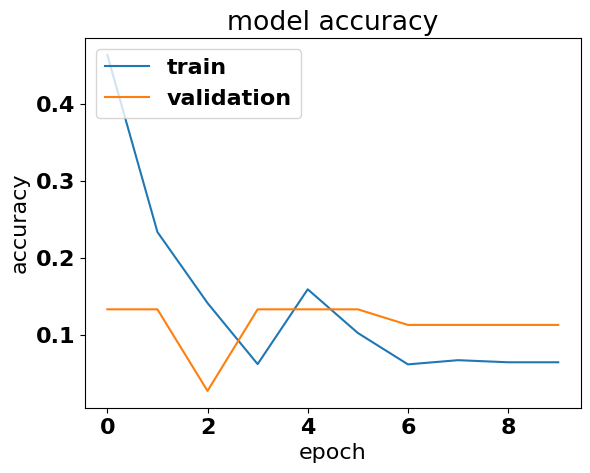

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
model.evaluate(val_dataset, batch_size=BATCH_SIZE, verbose=1)

40/40 [==============================] - 2s 49ms/step - loss: 2.5389 - accuracy: 0.1125


[2.538851261138916, 0.11249999701976776]

In [ ]:
predictions = model.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)

40/40 [==============================] - 2s 13ms/step


In [ ]:
predictions

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**Note** again that is just another baseline that only uses the `image` as the input and generates predictions after freezing all the layers for that base model.

Go wild and try different architectures and approaches, use several modalities, apply augmentations on the preprocessing layers, predict several targets at the same time, etc!

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["secondary_color_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]
].to_parquet(f"predictions_{student_id}.parquet")